# test ABM with standard test functions


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi
# from opteval import benchmark_func as bf
import matplotlib

#for server:
# matplotlib.use('Agg')

#for retina display:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import copy
import time as timer
import threading

from multiprocessing import Pool
from playsound import playsound
# from sklearn import linear_model

## Helper Functions

In [61]:
def cp(x): #make a copy instead of reference
    return copy.deepcopy(x)

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def isNaN(num):
    return num != num

def mean(x):
    return np.mean(x)

def norm(x):
    return float(np.linalg.norm(x))

def dist(x,y):
    return np.linalg.norm(np.array(x)-np.array(y))

def bounds(x,low,high):
    if x > high:
        return high
    if x < low:
        return low
    return x

def pScore(A,B):#ANOVA of 2 independent samples: are differences significant?
    _, p = scipy.stats.ttest_ind(A,B)
    return p 

def aiColor(ai): #red for innovators, blue for adaptors
    ai01 = bounds((ai - 40)/ 120,0,1)
    red = ai01
    blue = 1 - ai01
    return (red,0,blue)

In [3]:
def makeAiScore():
    ai = np.random.normal(97,17)
    ai = bounds(ai, 40,150)
    return ai

def makeIqScore(): #this IQ ranges from 0 to 1, bc it is basically efficiency
    iq = np.random.normal(0.5,0.2)
    iq = bounds(iq, 0.1,1.0)
    return iq

def pickWorseScore(betterScore,worseScore,temperature):
    if temperature <=1E-6: #never pick worse answers, and avoid devide by 0
        return False
    if np.random.uniform(0,1) < np.exp((betterScore-worseScore)/temperature):  #
        return True 
    return False

def calculateDecay(steps,T0=1.0,Tf=0.01):
    if T0<=Tf or T0<=0: 
        return 0
    return (Tf / float(T0) ) ** (1/steps)
  
def calculateAgentDecay(agent, steps):
    E_N = normalizedE(agent.kai.E)
    E_transformed = np.exp((E_N*-1)+2)
    startEndRatio = bounds(1/E_transformed, 1E-10,1)
#     print("ratio: %s" % startEndRatio)
    T0 = agent.temp
    TF = T0 * startEndRatio
    return calculateDecay(steps,T0,TF)#, startEndRatio

In [4]:
es = []
kais = []
ratios = []
for i in range(500):
    a = Agent()
    d, ratio = calculateAgentDecay(a,100)
    es.append(a.kai.E)
    kais.append(a.kai.KAI)
    ratios.append(ratio)
plt.scatter(es, ratios)
plt.show()
plt.scatter(kais, ratios)

NameError: name 'Agent' is not defined

In [5]:
def chaching():
    playsound("/Users/samlapp/SAE_ABM/missionComplete.wav")

## global constants and parameters

In [6]:
complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
commBonus = 10 #increasing the communication bonus makes successful communication more likely
commRange = 180
pCommTime = None
selfBias = 0 #increasing self bias will make agents choose their solutions more over others
startRange = 1
nDims = 56

SO_STRENGTH = 10
RG_STRENGTH = 10
TEAM_MEETING_COST = 1 #1 turn
ROUGHNESS = .025
w_global = 100

VERBOSE = False
showViz = False

AVG_SPEED = 7.0E-3
SD_SPEED = 7.0E-4
MIN_SPEED = 1.0E-4
AVG_TEMP = 1
SD_TEMP = 0.5
UNIFORM_SPEED = False
startPositions = None

steps = 500 #0 #100
nAgents = 33
# constructor = Wteinway
pComm = 0.2
pCommTime = None
meetingTimes = steps #have one meeting at the end
startHavingMeetings = 0

# Objectives

In [7]:
#implement four classic test optimization functions, and my tuneable roughness one

In [8]:
def objectiveTune(x,roughness=.05,w=100):
    a = roughness
    b = 2
    x = np.array(x)
    xEach = -1*a*np.sin((x*w+np.pi/2)) + b*(x)**2 + roughness #min is zero at zero vector
    y = sum(xEach)
    return y

In [9]:
def constrain(x):
    for i in range(len(x)):
        x[i] = bounds(x[i],-1,1)
    return x

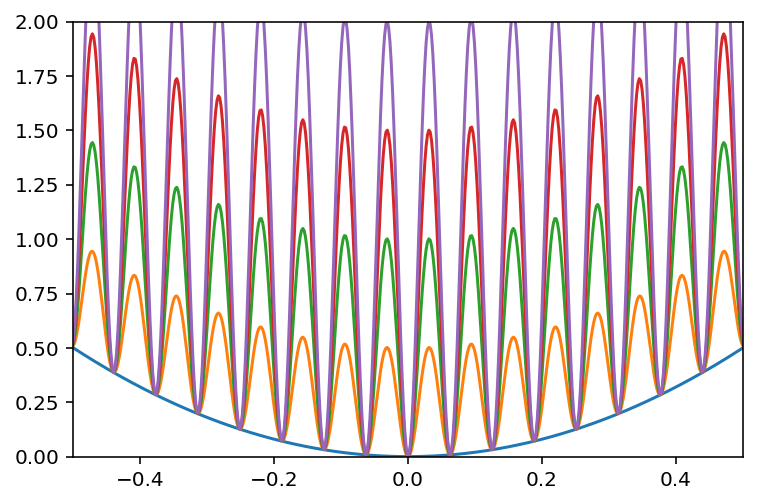

In [10]:
x = np.linspace(-1,1,1000)
for ROUGHNESS in np.linspace(0,1,5):#= 0.05
    y=[objectiveTune([xi],ROUGHNESS) for xi in x]
    plt.plot(x,y)

    plt.xlim([-.5,.5])
    plt.ylim([0,2])

## new objective

In [11]:
g = crescentGs[0]

NameError: name 'crescentGs' is not defined

In [12]:
# def f1(x,p=1,c=0):
#     return (x+c)**p
def generateComposite(ws,ps,cs):
    return lambda x: np.sum([ws[i]*(x-cs[i])**ps[i] for i in range(len(ws))])

def generateConstraint(alpha,beta,gamma,i,j):
    return lambda x: alpha*((x[i]-gamma[0])**2+(x[j]-gamma[1])**2 - beta**2)

def generateConstraint2(alpha,beta,gamma,nDims):
    return lambda x: alpha*(sum([(x[i]-gamma[i])**2 for i in range(nDims)]) - beta**2)

def generateFunctionsNdims(n):
    allF = []
    for i in range(n): 
        ws = np.random.uniform(-1,1,3)
        ws[2] = ws[2] * 10
        ps = [3,3,1]
        cs = np.random.uniform(-1,1,3)
        f = generateComposite(ws,ps,cs)
        allF.append(f)
    return allF

#constraints: g(x)<= 0
def generateConstraints(n,nDims):
    gs = []
    alphas = [-1,1]
    for i in range(n):
        alpha = alphas[i]#np.random.choice([-1,1]) #inside or outside
        beta = np.random.uniform(.3,.8) #size of circle
        gamma = np.random.uniform(-.2,.2,nDims)#2 #center of circle
#         i,j = np.random.choice(range(nDims),2,replace=False) #dimensions to constrain
#         g = generateConstraint(alpha,beta,gamma,i,j)
        g = generateConstraint2(alpha,beta,gamma,nDims)
        gs.append(g)
    return gs

def evalX(fs,x,gs=[]):
    y = 0
    for i in range(len(x)):
        f = fs[i]
        y+= f(x[i])
        if abs(x[i]) > 1:
            return 1E18  
        
    for g in gs: #composite constraints
        if g(x)>0:
            return 1E18
    return y

def evalXpeacewise(fs,x,gs=[]):
    y = 0
    for i in range(len(x)):
        f = fs[i]
        y+= f(x[i])
        if abs(x[i]) > 1:
            return 1E18
        
    #make a peacewise domain:
    inDomain = False
    for g in gs: #if it satisfies ANY constraint, it passes
        if g(x)<=0:
            inDomain = True
    if not inDomain:
        return 1E18

    return y

# crescentFs = generateFunctionsNdims(nDims)
# crescentGs = generateConstraints(2,nDims)

In [13]:
# print( [gs[i]([1,1,1]) for i in range(len(gs))])

In [14]:
# fs = generateFunctionsNdims(3)
# gs = generateConstraints(2)
# # evalX(fs,[0,0,.1],gs)

In [15]:
nDims = 10
# fs = generateFunctionsNdims(nDims)
# gs = generateConstraints(2,nDims)
size = 100
x1 = np.linspace(-1,1,size)
x2 = np.linspace(-1,1,size)
y = np.zeros([size,size])
d1 = 0
for d2 in range(1,nDims):
    for i in range(len(x1)):
        for j in range(len(x2)):
            x = np.zeros(nDims)
            x[d1] = x1[i]
            x[d2] = x2[j]
            yi = evalX(fs,x, gs)
            yi = min(yi,100)
            y[i,j] = yi

    np.shape(y)
    plt.imshow(y)
    plt.colorbar()
    plt.show()
# evalX(fs,x)

NameError: name 'fs' is not defined

In [16]:
# crescentFs = cp(fs)
# crescentGs = cp(gs)

In [17]:
# x = np.linspace(-1,1,100)

# dims = 2
# gridSize = 100
# xi = np.linspace(-1,1,gridSize)
# # y = np.zeros(100,dims)
# fs = []
# for i in range(dims):
#     weights = np.random.uniform(-1,1,size=3)
#     w = 3
#     def f(x):
#         try:
#             weights = myWeights
#         except UnboundLocalError:
#         myWeights = cp(weights)
#         return weights[0]*f1(x*w,3,.8) + weights[1]*10*f1(x*w,1,.5) + weights[2]*f1(x*w,3,.2)
#     fs.append(f)
# #     plt.plot(x,f1(x,0,.5))
# #     plt.plot(x,y)

# #negative null form: () <= 0
# # g1(x) = 

In [18]:
f0 = fs[1]
f0(1)

NameError: name 'fs' is not defined

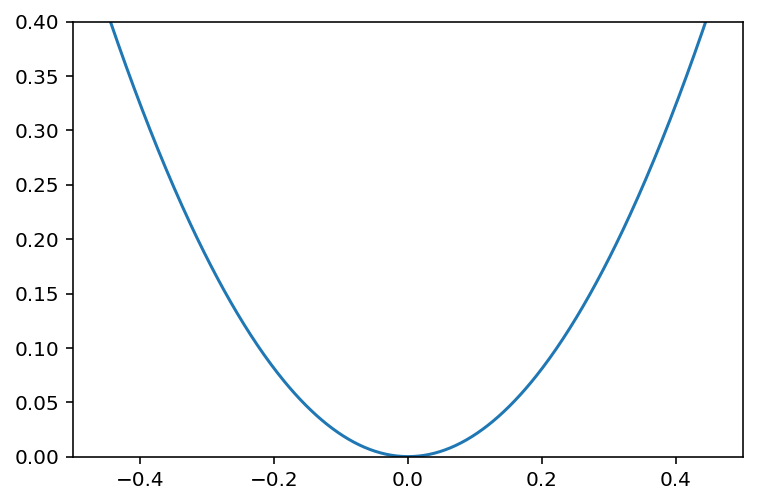

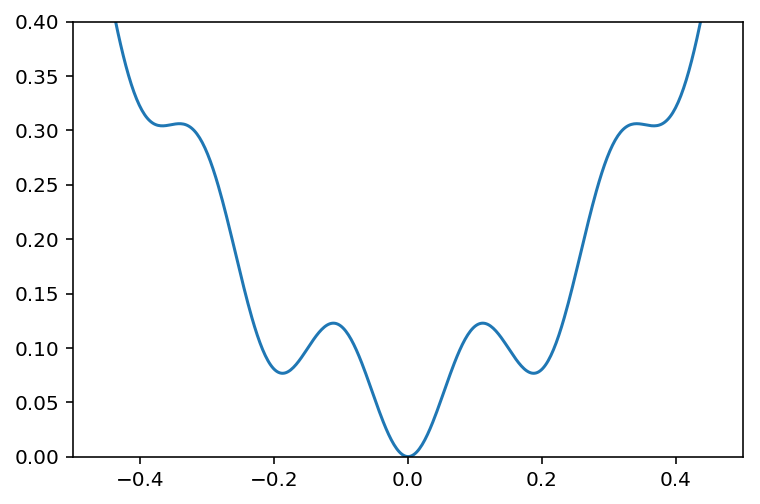

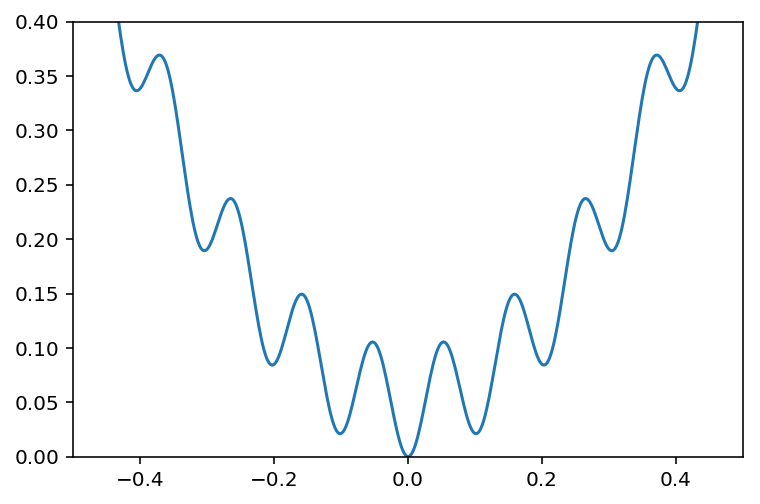

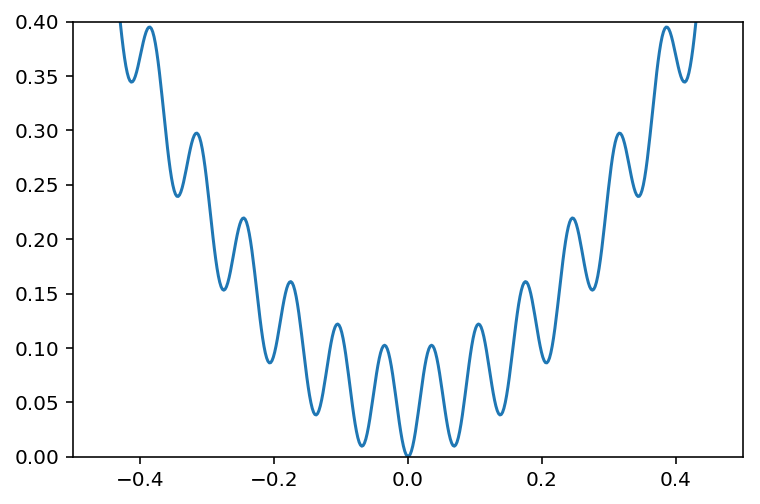

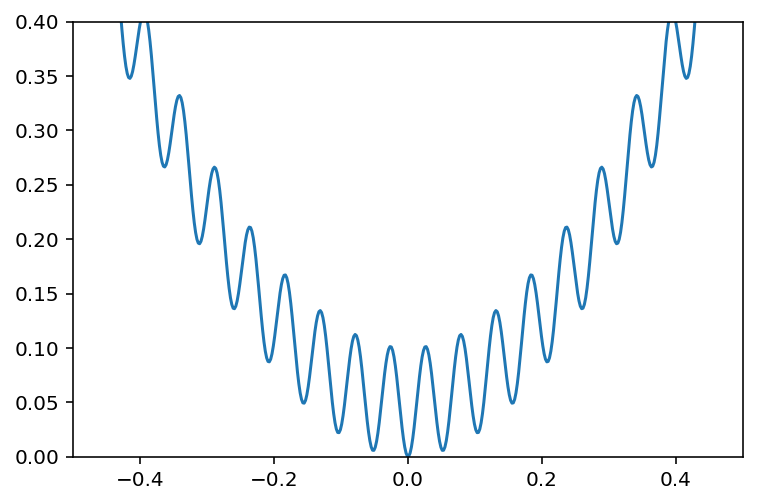

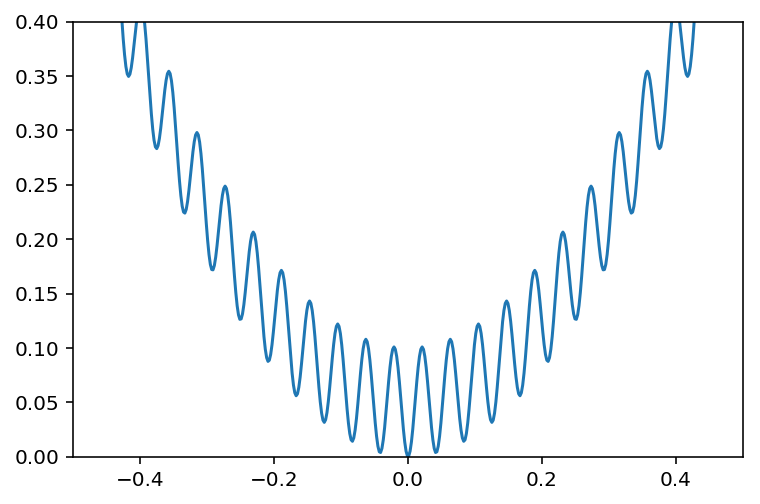

In [19]:
x = np.linspace(-1,1,1000)
ROUGHNESS = 0.025
for w in np.linspace(1,150,6):#= 0.05
    y=[objectiveTune([xi],w=w) for xi in x]
    plt.plot(x,y)
    plt.xlim([-.5,.5])
    plt.ylim([0,.4])
    plt.show()

# Create Virtual Population with represntative KAI scores 
based on KAI score and subscore dataset provided by Dr. J

In [20]:
kaiDF_DATASET = pd.read_csv("./KAI/KAI_DATA_2018_07_09.csv")
kaiDF_DATASET.columns = ["KAI","SO","E","RG"]
def makeKAI(n=1,asDF=True):
    pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
    if asDF:
        popDF = pd.DataFrame(pop) 
        popDF.columns = kaiDF_DATASET.columns
        return popDF if n>1 else popDF.loc[0]
    else:
        return pop if n>1 else pop[0]
    
# def makeSubscores(kai,n=1,asDF=True):
#     pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
kaiPopulation = makeKAI(100000)
kaiPopulation=kaiPopulation.round()

In [112]:
def findAiScore(kai):
    kai = int(kai)
    a = kaiPopulation.loc[kaiPopulation['KAI'] == kai]
    ind = np.random.choice(a.index)
    me = kaiPopulation.loc[ind]
    return KAIScore(me) #this is a KAIScore object

def calcAgentSpeed(kai):
#     speed = bounds(AVG_SPEED + normalizedAI(kai) * SD_SPEED, MIN_SPEED ,np.inf)
    speed = bounds(np.exp(normalizedAI(kai))* AVG_SPEED, MIN_SPEED ,np.inf)
    return speed

def calcAgentTemp(E):
#     return bounds(AVG_TEMP + normalizedE(E) * SD_TEMP, 0 ,np.inf)
    return np.exp(normalizedE(E)*AVG_TEMP)

0.02000367842527316

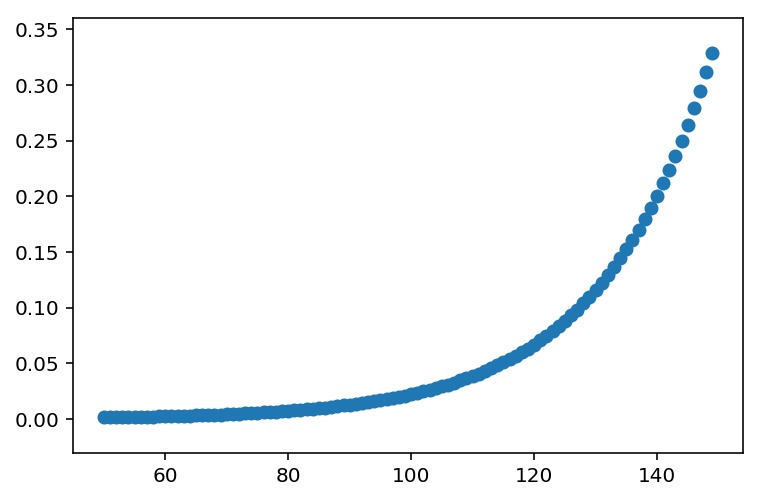

In [111]:
k= range(50,150)
s=[]
for i in k:
    s.append(calcAgentSpeed(i))
plt.scatter(k,s)
calcAgentSpeed(98)

In [22]:
AVG_TEMP

1

3936704.691936439

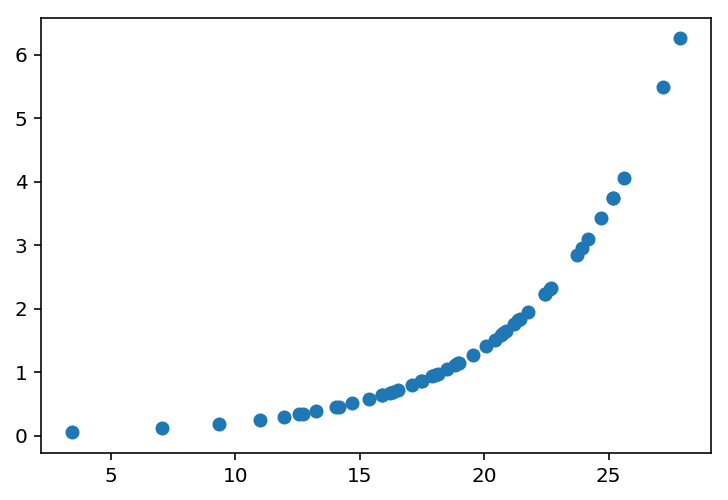

In [105]:
k= [Agent() for i in range(50)]
s=[]
Es = []
for a in k:
    E = a.kai.E
    Es.append(E)
    s.append(calcAgentTemp(E))
plt.scatter(Es,s)
calcAgentTemp(98)

In [25]:
def normalizedAI(ai):
    return (ai - kaiDF_DATASET.mean().KAI)/kaiDF_DATASET.std().KAI
def normalizedRG(rg):
    return (rg - kaiDF_DATASET.mean().RG)/kaiDF_DATASET.std().RG
def normalizedE(E):
    return (E - kaiDF_DATASET.mean().E)/kaiDF_DATASET.std().E
def normalizedSO(SO):
    return (SO - kaiDF_DATASET.mean().SO)/kaiDF_DATASET.std().SO

In [26]:
kaiDF_DATASET.mean().E
kaiDF_DATASET.std().E

5.251845955448993

In [27]:
def dotNorm(a,b): #return normalized dot product (how parallel 2 vectors are, -1 to 1)
    if norm(a) <= 0 or norm(b)<= 0:
#         print("uh oh, vector was length zero")
        return 0
    a = np.array(a)
    b = np.array(b)
    dotAB = np.sum(a*b)
    normDotAB = dotAB / (norm(a)*norm(b))
    return normDotAB

In [28]:
def plotCategoricalMeans(x,y):
    categories = np.unique(x)
    means = []
    sds = []
    for c in categories:
        yc = [y[i] for i in range(len(y)) if x[i] == c]
        means.append(np.mean(yc))
        sds.append(np.std(yc))
    plt.errorbar(categories,means,yerr=sds,marker='o',ls='none')
    
    return means

In [29]:
#speed distributions:
dfConstant=1.9
def travelDistance(speed): #how far do we go? chi distribution, but at least go 0.1 * speed
    r = np.max([chi.rvs(dfConstant),0.1]) 
    return r * speed

In [30]:
def memoryWeightsPrimacy(n):
    if n==1:
        return np.array([1])
    weights = np.arange(n-1,-1,-1)**3*0.4 + np.arange(0,n,1)**3
    weights = weights / np.sum(weights)
    return weights

In [31]:
def makeParamString():
    s= ""
    s+= "steps: "+ str(steps) + " \n"
    s+= "self-bias: " +str(selfBias)+ " \n"
    s+= "num agents: " +str(nAgents)+ " \n"
    s+= "rg strength: " +str(RG_STRENGTH)+ " \n"
    s+= "so strength: " +str(SO_STRENGTH)+ " \n"
    s+= "repeats: " +str(reps)+ " \n"
    s+= "avg speed: " +str(AVG_SPEED) + " \n"
    s+= "sd speed: " + str(SD_SPEED)+ " \n"
    s+= "min speed: " +str(MIN_SPEED)+ " \n"
    s+= "avg temp: "+ str(AVG_TEMP)+ " \n"
    s+= "sd temp: " +str(SD_TEMP)+ " \n"
    return s

## Agent and Team Classes

In [32]:
class Agent:
    def __init__(self, id=-1):
        self.id = id
        self.score = np.inf
        self.r = np.random.uniform(size=nDims)
        self.nmoves = 0
        self.kai = KAIScore()
        self.speed = calcAgentSpeed(self.kai.KAI)
        self.temp = calcAgentTemp(self.kai.E)
        self.iq = 1 #makeIqScore()
        self.memory = [Solution(self.r,self.score,self.id,type(self))]
        self.team = -1
        self.decay = calculateAgentDecay(self,100)
        self.startTemp = cp(self.temp)
        self.startSpeed = cp(self.speed)
        
    def move(self,soBias=False,groupConformityBias=False,teamPosition=None):
        if np.random.uniform()>self.iq: #I'm just thinking this turn
            return False 
        
#         print("my dimensions:" +str(self.myDims))
        #pick a new direction
        d = np.random.uniform(-1,1,nDims)
        d = d * self.myDims #project onto the dimensions I can move
        dn = np.linalg.norm(d)
        if dn==0: print("divide by zero (dn)")
        #distance moved should be poisson distribution, rn its just my speed
        distance = travelDistance(self.speed) * nDims
        d = d / dn * distance
#         print('considering moving '+str(d) + ' from '+str(self.r))
        candidateSolution = (self.r + d)
        candidateSolution = constrain(candidateSolution)
        
        acceptsNewSolution = self.evaluate(candidateSolution,soBias,groupConformityBias,teamPosition=teamPosition)
        if acceptsNewSolution: 
            self.moveTo(candidateSolution)
            return True
#         self.score = self.f()
        return False

    def moveTo(self, r):
        self.r = r
        self.score = self.f()
        self.memory.append(Solution(self.r,self.score,self.id,type(self)))
        self.nmoves += 1
        
    def startAt(self,position):
        self.r = position
        self.memory = [Solution(r=self.r,score=self.f(),owner_id=self.id,agent_class=type(self))]

    def wantsToTalk(self,pComm):
        if(np.random.uniform() < pComm):
            return True
        return False
    
    def getBestScore(self):
        bestScore = self.score
        for s in self.memory:
            if s.score < bestScore:
                bestScore = s.score
        return bestScore
    
    def getBestSolution(self):
        bestSolution = cp(self.memory[0])
        for m in self.memory:
            if m.score < bestSolution.score:
                bestSolution = m
        return bestSolution
    
    def soBias(self,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        #positions should be given as NORMALIZED positions on unit cube! 
        soNorm = normalizedSO(self.kai.SO) #normalized score for Sufficiency of Originality
        memSize = len(self.memory) 
        if memSize < 2: return 0 #we don't have enough places be sticking around them
        
        candidateDirection = candidatePosition - currentPosition #in unit cube space
        
        memDirection = 0 # what is the direction of past solns from current soln?
        weights = memoryWeightsPrimacy(memSize) #weights based on temporal order, Recency and Primacy Bias
        for i in range(memSize-1): #don't include current soln
            past_soln = self.memory[i]
            pairwiseDiff = past_soln.r - currentPosition
            memDirection += pairwiseDiff * weights[i]
        #now we see if the new solution is in the direction of the memories or away from the memories
        paradigmRelatedness = dotNorm(memDirection, candidateDirection)
        raw_PR_score = soNorm * (paradigmRelatedness + 0) #shifting the x intercept #biasOfSO(PR,soNorm)
        sufficiency_of_originality = raw_PR_score*SO_STRENGTH #the agent should have a memory of their path & interactions
            
        return sufficiency_of_originality
    
    def groupConformityBias(self,teamPosition,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        rgNorm = normalizedRG(self.kai.RG) #normalized score for Rule/Group Conformity
        candidateDirection = candidatePosition - currentPosition 
        
        #all teammates have equal weight
        teamDirection = teamPosition - currentPosition

        #now we see if the new solution is in the direction of the team or away from the team
        groupConformity = dotNorm(teamDirection, candidateDirection)
        nominalGC = 0 #can change intercept with -0 (using dot product of direction,so is perpendicular the null case?)
        groupConformityBias = (groupConformity-nominalGC)*rgNorm*RG_STRENGTH 
        return groupConformityBias
    
    def evaluate(self,candidateSolution,soBias=False,groupConformityBias=False,teamPosition=None): #implements simulated annealing greediness
        candidateScore = self.fr(candidateSolution)
        if soBias:
            candidateScore += self.soBias(self.r,candidateSolution)
        if groupConformityBias:
            gcB = self.groupConformityBias(teamPosition,self.r,candidateSolution)
            candidateScore += gcB
        #if better solution, accept
        if candidateScore < self.score:
            return True
        #accept worse solution with some probability, according to exp((old-new )/temp)
        elif pickWorseScore(self.score,candidateScore,self.temp):
            self.score = candidateScore #(its worse, but we go there anyways)
            return True              
        return False
    
    
#Solutions are objects
class Solution():
    def __init__(self, r,  score, owner_id=None, agent_class=None):
        self.r = cp(r)
#         self.rNorm = self.r / scalingVector
        self.score = cp(score)
        self.owner_id = cp(owner_id)
        self.agent_class = cp(agent_class)
        
#KAI scores are objects 
class KAIScore():
    def __init__(self,subscores=None):
        if subscores is None:
            subscores = makeKAI(1,True)
        self.KAI = subscores.KAI
        self.SO = subscores.SO
        self.E = subscores.E
        self.RG = subscores.RG
    
class Crescent(Agent): #randomized functions and constraints
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return evalX(crescentFs,self.r,crescentGs)
    def fr(self,r):
        return evalX(crescentFs,r,crescentGs)
    
class PeaceWise(Agent): #randomized functions and constraints
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return evalXpeacewise(crescentFs,self.r,crescentGs)
    def fr(self,r):
        return evalXpeacewise(crescentFs,r,crescentGs)
    
class Steinway(Agent): #tuneable roughness
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return objectiveTune(self.r,ROUGHNESS,w_global)
    def fr(self,r):
        return objectiveTune(r,ROUGHNESS,w_global)

def tryToShare(a1,a2):
    deltaAi = abs(a1.kai.KAI - a2.kai.KAI) #harder to communicate above 20, easy below 10
    deltaR = np.linalg.norm(a1.r - a2.r)
    successful =  tryComm(deltaAi,deltaR)
    if successful: #in share(), agents might adopt a better solution depending on their temperature
        share(a1,a2) if complexSharing else shareBasic(a1,a2)
        return True
    return False
  
def shareBasic(a1,a2): #agents always go to better solution
    if a1.score < a2.score:
        a2.moveTo(a1.r)
    elif a2.score < a1.score:
        a1.moveTo(a2.r)
    return True

def share(a1,a2): #agent chooses whether to accept new solution or not, holistic NOTTTTTT dimension by dimension
    copyOfA1 = cp(a1)
    considerSharedSoln(a1,a2)
    considerSharedSoln(a2,copyOfA1) #so they could theoretically swap positions...
    return True

def considerSharedSoln(me,sharer): #,dim): #will only move (jump) in the dimensions that sharer controls
#         candidateSoln = me.r #other dimensions won't change
#         candidateSoln[dim] = sharer.r[dim] #tells a1 where to go in This [i] dimension only
        candidateSolution = sharer.r
        candidateScore = me.fr(candidateSolution)
        myScore = me.score - selfBias #improve my score by selfBias
        #Quality Bias Reduction? would go here
        if(candidateScore<myScore):
            if not pickWorseScore(candidateScore,myScore,me.temp): #sometimes choose better, not always
                me.moveTo(candidateSolution)  #(but never take a worse score from a teammate)
#                 me.speed = me.startSpeed
#                 me.temp = me.startTemp # !! CHRIS trying somethign new here: restart temp at teammate's soln
constructor = Steinway

In [33]:
# commBonus = 0
# commRange = 200
hardShareDist = 0
def tryComm(deltaAi,deltaR= 0 ):
    c = np.random.uniform(commBonus,commBonus+commRange) #increasing commBonus makes sharing easier 
    #sharing can also fail when distance is far
    spaceSize = np.sqrt(nDims)
    d = np.random.uniform(spaceSize,spaceSize*hardShareDist)
    return (deltaAi < c and deltaR < d)

In [34]:
import scipy
a = [np.random.uniform(size=2) for i in range(10)]
a[0] = np.array([0,0])
a[1] = np.array([1,0])
a[9] = np.array([0,0])
print(a)
np.mean(scipy.spatial.distance.pdist(a))

[array([0, 0]), array([1, 0]), array([0.72208913, 0.51209843]), array([0.7024222 , 0.61024018]), array([0.76072172, 0.43220144]), array([0.69239309, 0.25218397]), array([0.79628485, 0.16523342]), array([0.25683217, 0.15923469]), array([0.45327167, 0.93216347]), array([0, 0])]


0.587671895995975

In [35]:
class Team(): #a group of agents working on the same dimension and objective function
    def __init__(self, nAgents, agentConstructor, dimensions = np.ones(nDims), specializations = None, temp=None,speed=None,aiScore=None,aiRange=None,startPositions=None):
        self.agents = []
        self.dimensions = dimensions
        if (aiScore is not None) and (aiRange is not None):
            minScore = np.max([40, aiScore-aiRange/2.0])
            maxScore = np.min([150,aiScore+aiRange/2.0])
            aiScores = np.linspace(minScore,maxScore,nAgents)
            np.random.shuffle(aiScores) #randomly assign these to agents, not in order...
            #or we could try putting them in subteams according to a rule:
            
        for i in range(nAgents):
            a = agentConstructor(id = i)
            if startPositions is not None:
                a.startAt(startPositions[i])
            if (aiScore is not None) and (aiRange is not None):
                aiScore = aiScores[i]
                a.kai = findAiScore(aiScore)
                a.speed = calcAgentSpeed(a.kai.KAI)
                a.temp = calcAgentTemp(a.kai.E)
            if speed is not None:
                a.speed = speed
            if temp is not None:
                a.temp = temp
            a.startSpeed = a.speed
            a.startTemp = a.temp
            a.myDims = dimensions #default: all dimensions owned by every agent
            if UNIFORM_SPEED:
                a.speed = AVG_SPEED
            self.agents.append(a)
        self.nAgents = nAgents
        aiScores = [a.kai.KAI for a in self.agents]
        self.dAI = np.max(aiScores)- np.min(aiScores)
        self.nMeetings = 0
        self.shareHistory = []
        self.nTeamMeetings = 0
        self.subTeamMeetings = 0
        self.meetingDistances = []
        
        self.scoreHistory = []
        
        #if there are subteams owning certain dimensions, each subteams dimensions are listed in a matrix
        self.specializations = specializations
        
#         #we should give them same position in the dimensions they don't control
#         a0 = self.agents[0]
#         for i in range(len(a0.myDims)):
#             if not a0.myDims[i]:  #this isn't our dimension to control
#                 for a in self.agents: 
#                     a.r[i] = a0.r[i] 

    def getSharedPosition(self): #this is in the normalized space
        positions = np.array([a.r for a in self.agents])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getSubTeamPosition(self,team): #this is in the normalized space
        positions = np.array([a.r for a in self.agents if a.team == team])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getBestScore(self):
        return np.min([a.getBestScore() for a in self.agents])
    
    def getBestCurrentScore(self):
        return np.min([a.score for a in self.agents])
    
    def getBestSolution(self):
        allSolns = [a.getBestSolution() for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestCurrentSolution(self):
        allSolns = [a.memory[-1] for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestTeamSolution(self,team=-1): #returns a Solution object 
        bestIndividualSolns = [a.getBestSolution() for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in bestIndividualSolns])
        return bestIndividualSolns[bestScoreLocation]
    
    def getBestCurrentTeamSolution(self,team=-1): #returns a Solution object 
        individualSolns = [a.memory[-1] for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in individualSolns])
        return individualSolns[bestScoreLocation]
    
    def haveMeetings(self,talkers):
        nMeetings = 0
        for i in np.arange(0,len(talkers)-1,2):
            a1 = talkers[i]
            a2 = talkers[i+1]
            didShare = tryToShare(a1,a2)
            if didShare: 
#                 print(str(a1.id) + ' and '+str(a2.id)+' shared!')
                nMeetings +=1
        self.nMeetings += nMeetings
        self.shareHistory.append(nMeetings)
        return nMeetings
    
    def haveTeamMeeting(self):
        #they all go to the best CURRENT position of the group
        bestSolution = self.agents[0].memory[-1]
        for a in self.agents:
            agentCurrent = a.memory[-1]
            if agentCurrent.score < bestSolution.score:
                bestSolution = agentCurrent
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveSubTeamMeeting(self,team,gap=False):
        #they all go to the best position of their specialized team
        teamAgents = [a for a in self.agents if a.team == team]
        if gap: #the meeting might fail if the cognitive style gap is large
            #take the KAI differences of the team into account
            kaiScores = [a.kai.KAI for a in teamAgents]
            deltaAi = max(kaiScores) - min(kaiScores) #hard to communicate above 20, easy below 10
            successful =  tryComm(deltaAi)
            if not successful: #in share(), agents might adopt a better solution depending on their temperature
                return None  #our cognitive style gap caused the meeting to fail (only if complexSharing=True)
        #ok, phew, we have a successful meeting despite any cognitive gap:
        bestSolution = teamAgents[0].memory[-1]
        for a in teamAgents:
            agentCurrent = a.memory[-1]
            if agentCurrent.score < bestSolution.score:
                bestSolution = agentCurrent
        #now move all agents to this position
        for a in teamAgents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveInterTeamMeeting(self): #when you have teams of teams
        allPositions = [a.r for a in self.agents]
        teamDistance_Sum = sum(scipy.spatial.distance.pdist(allPositions))
#         print(teamDistance_Sum)
        #how much does the meeting cost? increases with distance
        cost = min(int(teamDistance_Sum / nDims),15)
#         print(cost)
        #if the meeting takes to long, does it fail?
#         if cost
        
        consensusPosition = np.zeros(nDims)
        #get the best solution from each specialized subteam, and extract their specialized dimensions 
        for team in range(len(self.specializations)):
            bestTeamSoln = self.getBestCurrentTeamSolution(team)
            specializedInput = bestTeamSoln.r * self.specializations[team]
            consensusPosition += specializedInput
        consensusPosition = constrain(consensusPosition)
        consensusScore = self.agents[0].fr(consensusPosition)
        
        #calculate how far everyone had to move
        individualDistances = allPositions-consensusPosition
        meetingDistance = np.mean(scipy.spatial.distance.pdist(individualDistances))
        kaiDistance = np.mean(scipy.spatial.distance.pdist([[a.kai.KAI] for a in self.agents]))/100
        self.meetingDistances.append(meetingDistance*kaiDistance)
        
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(consensusPosition)
        
        self.nTeamMeetings += 1
        
        return cost #[consensusScore, consensusPosition]
    
    
    def step(self,pComm,showViz=False,soBias=False,groupConformityBias=False):
        #what happens during a turn for the team? 
        #each agents can problem solve or interact (for now, inside team)
        talkers = []
        for a in self.agents:
            if a.wantsToTalk(pComm):
                talkers.append(a)
            else: #CHANGE: getSharedPosition looks only at your subteam members
                teamPosition = self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        if len(talkers)%2>0: #odd number, have last one explore instead of share
            a = talkers.pop()
            teamPosition = self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
            didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        nMeetings = self.haveMeetings(talkers)
#         print("number of successful meetings: "+str(nMeetings))
        
#         if showViz:
#             self.plotPositions()
        
        self.updateTempSpeed()
            
        return nMeetings
    
    def updateTempSpeed(self):
        for a in self.agents:
            a.temp *= a.decay
            a.speed *= a.decay
               
    def plotPositions(self):
        xs = [a.r[0] for a in self.agents]
        ys = [a.r[1] for a in self.agents]
        cs = [aiColor(a.kai.KAI) for a in self.agents]
        plt.scatter(xs,ys, c=cs)
#         teamPosition = self.getSharedPosition()
#         plt.scatter(teamPosition[0],teamPosition[1],c='orange')
        
                

## Tune Comm Bonus

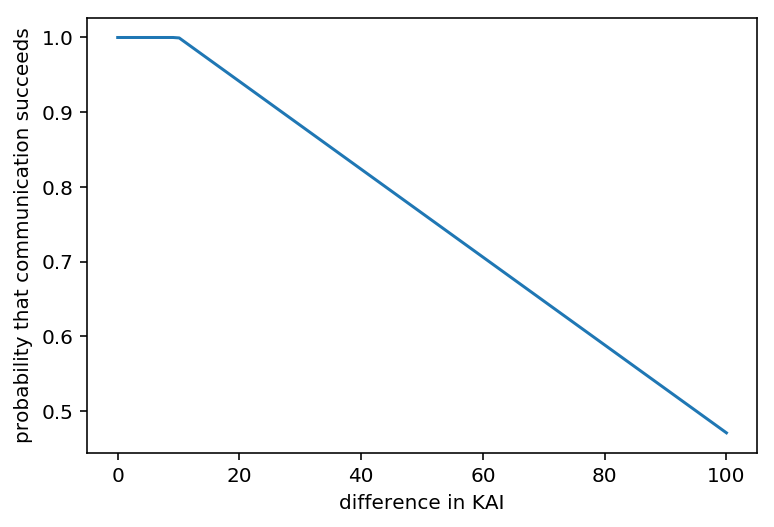

In [36]:
deltaAis = np.linspace(0,100,100)
# pSuccess = []
# for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
#     successful = []
#     for i in range(1000):
#         successful.append(tryComm(deltaAi))
#     pSuccess.append(np.mean(successful))
theoreticalP = [min(1 - (d-10)/170,1) for d in deltaAis]
plt.plot(deltaAis,theoreticalP)
# plt.plot(deltaAis,pSuccess)
plt.xlabel("difference in KAI")
plt.ylabel("probability that communication succeeds")
plt.savefig("./figs/successfullP.pdf")

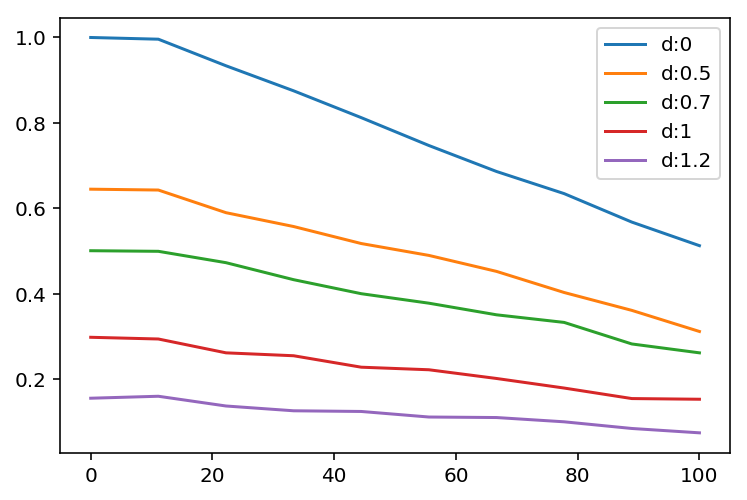

In [37]:
deltaAis = np.linspace(0,100,10)
nDims = 2
distances = [0,.5,.7, 1,1.2]
for dist in distances:
    pSuccess = []
    for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
        successful = []
        for i in range(5000):
            successful.append(tryComm(deltaAi,dist))
        pSuccess.append(np.mean(successful))
    plt.plot(deltaAis,pSuccess, label='d:%s' % dist)
# plt.plot(deltaAis,pSuccess)
plt.legend()

# Individual Exploration

In [38]:
# def work(AgentConstructor,steps=100,ai=None,temp=None, speed=None, showViz=False, soBias=False, groupConformityBias = False, color = 'red',startPosition = None,teamPosition=None):    
#     a = AgentConstructor()
#     if ai is not None:
#         a.kai = findAiScore(ai)
#         self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
#         self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
#     if startPosition is not None:
#         a.startAt(startPosition)
#     if temp is not None:
#         a.temp = temp
#     if speed is not None:
#         a.speed = speed
    
#     a.decay = calculateAgentDecay(a, steps)

#     scores = []
#     shareSuccess = []          

#     for i in range(steps):
#         didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias,teamPosition = teamPosition)
#         if didMove:
#             scores.append(copy.deepcopy(a.score))
#             if(showViz and a.nmoves>0):
# #                     plt.scatter(a.rNorm[0],a.rNorm[1],c=color)
#                 plt.scatter(a.rNorm[0],a.score,c=color)
#         a.speed *= a.decay
#         a.temp *= a.decay

#     return a

# Team Work

In [39]:
# meetingTimes = 20
def teamWork(teamSize,agentConstructor, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions)
    for a in squad.agents:
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0
    while i < steps:
        meetingTotal += squad.step(pComm,showViz,soBias,groupConformityBias) 
#         if showViz: 
#             rGroup = squad.getSharedPosition()
#             plt.scatter(rGroup[0],rGroup[1],marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
            if(showViz): 
                plt.show()
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

# meetingTimes = 20
def teamWorkSpecialized(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    np.random.seed()
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        meetingTotal += squad.step(0,showViz,soBias,groupConformityBias)  #putting 0 for pComm here!
        score = squad.getBestCurrentScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            cost = squad.haveInterTeamMeeting()
            i += cost
#             if showViz: 
#                 plt.show()

        #use pComm for subTeam meetings instead of pair meetings
        for team in range(len(squad.specializations)): 
            if pComm > np.random.uniform(): #on any step there is some chance of having a meeting
                squad.haveSubTeamMeeting(team,gap=complexSharing)
                squad.subTeamMeetings += 1
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

startHavingMeetings = 0
def teamWorkSharing(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None, curatedTeams=False,pCommTime = pCommTime):
    np.random.seed()
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]

        a.decay = calculateAgentDecay(a,steps)
    if curatedTeams and aiRange is not None and aiScore is not None:
        for team in range(len(teamSpecializations)):
            teamAgents=[a for a in squad.agents if a.team == team]
            for i in range(len(teamAgents)):
                myKai = aiScore - aiRange/2.0 + aiRange*(float(i)/(len(teamAgents)-1)) 
                a= teamAgents[i]
                a.kai = findAiScore(myKai)
    for a in squad.agents:
        if UNIFORM_SPEED:
            a.speed = AVG_SPEED
        a.startSpeed = a.speed
                           
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
        pCommT = pComm
        if pCommTime is not None:
            timeFraction = float(i)/steps
            pCommT = pComm * pCommTime[int(timeFraction*len(pCommTime))]
        squad.nMeetings += squad.step(pCommT,showViz,soBias,groupConformityBias) 
        score = squad.getBestCurrentScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
#         if i == singleMeeting: 
        if (i+1)%meetingTimes == 0 and float(i)/steps >= startHavingMeetings:  #start having meetings later on?
            cost = squad.haveInterTeamMeeting()
            i += cost #TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()
        i += 1
    if showViz: plt.show()
    
    return squad

In [40]:
#define the team specializations and assign agents to teams
def specializedTeams(nAgents,nTeams):
    agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return agentTeams

def teamDimensions(nDims,nTeams):
    teamDims = np.array([[1 if t%nTeams == dim%nTeams else 0 for dim in range(nDims)] for t in range(nTeams)])
    return teamDims

def saeTeams(nAgents):
    for i in range(nAgents):
        agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return agentTeams

nDims = 56
nTeams = 11
nAgents = 33
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

In [75]:
def showScoreHistory(agent):
    mem = agent.memory
    for i in range(len(mem)):
        m = mem[i]
        plt.scatter(i,m.score,c='b')
    plt.show()
def showPath(agents):
    for agent in agents:
        mem = agent.memory
        dims = [i for i in range(len(agent.myDims)) if agent.myDims[i]>0]
        x = []
        y = []
        for i in range(len(mem)):
            m = mem[i]
            x.append(m.r[dims[0]])
            y.append(m.r[dims[1]])
        plt.scatter(x,y,c=aiColor(agent.kai.KAI))
        plt.scatter(agent.r[dims[0]],agent.r[dims[1]],marker='x',s=100,c=aiColor(agent.kai.KAI))
        plt.xlim([-1,1])
        plt.ylim([-1,1])
    plt.show()
# a0 = team.agents[9]
# showScoreHistory(a0)
# a0.myDims

In [42]:
#set standard Parameters
def resetDefaultParameters():
    global complexSharing
    complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
    global commBonus
    commBonus = 10 #increasing the communication bonus makes successful communication more likely
    global commRange
    commRange = 180
    global pCommTime
    pCommTime = None
    global selfBias
    selfBias = 0 #increasing self bias will make agents choose their solutions more over others
    global startRange
    startRange = 1
    global nDims
    nDims = 56

    global SO_STRENGTH
    SO_STRENGTH = 10
    global RG_STRENGTH
    RG_STRENGTH = 10
    global TEAM_MEETING_COST
    TEAM_MEETING_COST = 1 #1 turn

    global VERBOSE
    VERBOSE = False
    global showViz
    showViz = False

    global AVG_SPEED
    AVG_SPEED = 7.0E-3
    global SD_SPEED
    SD_SPEED = 7.0E-4
    global MIN_SPEED
    MIN_SPEED = 1.0E-4
    global AVG_TEMP
    AVG_TEMP = 1
    global SD_TEMP
    SD_TEMP = 0.8
    global UNIFORM_SPEED
    UNIFORM_SPEED = False
    global startPositions
    startPositions = None
    
    global ROUGHNESS
    ROUGHNESS = .025
    
    global w_global
    w_global = 100
    
    global steps
    steps = 500 #0 #100
    global nAgents
    nAgents = 33
    global constructor
    constructor = Steinway
    global teamDims
    teamDims = teamDimensions(nDims,nTeams)
    global agentTeams
    agentTeams = specializedTeams(nAgents,nTeams)
    
    global pComm
    pComm = 0.2
    global meetingTimes
    meetingTimes = steps #have one meeting at the end
    global startHavingMeetings
    startHavingMeetings = 0

## Use MultiProcessing for parallel computing

In [43]:
import multiprocessing
curatedTeams = False
def teamWorkProcess(processID):
    np.random.seed()
    team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange,curatedTeams=curatedTeams,pCommTime=pCommTime,startPositions=startPositions)
    return team

In [44]:
# !jupyter nbconvert --to script Chicago.ipynb

## Sharing: optimal rate is about 0.3

In [45]:
# plt.scatter(range(len(t.scoreHistory)),t.scoreHistory)

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComms = np.linspace(0,.5,3)
pComm = 0.2

steps = 100
reps = 4 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRange = 0
# aiRanges = np.linspace(0,100,10)

meetingTimes = 10000 

allTeamObjects = []
for pComm in pComms:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        print('moving on')
        for team in allTeams:
            allTeamObjects.append(team)
# allTeams = [t for tl in allTeamObjects for t in tl]
print("time to complete: "+str(timer.time()-t0))
allTeams = allTeamObjects
chaching()

In [ ]:
allScores = [t.getBestCurrentScore() for t in allTeamObjects]
pcx = [p for p in pComms for i in range(reps)]
plt.scatter(pcx,allScores, c=[.9,.9,.5])
plotCategoricalMeans(pcx,allScores)

## reproduce Bernstein et al 2018 

they found that intermittent links > none or always

none: better best performance

always: best avg performance

intermittent: good avg and best

In [ ]:
# plt.scatter(range(len(t.scoreHistory)),t.scoreHistory)

### Flat team

In [ ]:
t0 = timer.time()
resetDefaultParameters()
nAgents = 3
nTeams = 1
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

curatedTeams = False

# pComms = np.linspace(0,.5,3)
pComm = 0 

steps = 17
reps = 8 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRange = 0
# aiRanges = np.linspace(0,100,10)

TEAM_MEETING_COST = 0
meetingTimesArray = [1,2,3,.1] 

bernsteinTest = []
for meetingTimes in meetingTimesArray:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        print('moving on')
        bernsteinTest.append(allTeams)
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
allTeams = [t for a in bernsteinTest for t in a]
bernsteinScores = [t.getBestScore() for t in allTeams]

meetingStyle = [x for x in [0,1,2,3] for i in range(reps)]

plt.scatter(meetingStyle,bernsteinScores, c=[.9,.9,.5])
plotCategoricalMeans(meetingStyle,bernsteinScores)

## maybe with pComm instead of meetings

In [ ]:
t0 = timer.time()
resetDefaultParameters()
nAgents = 10
nTeamsArray = [1,2,5,10]

curatedTeams = False

# pComms = np.linspace(0,.5,3)
pComms = np.linspace(0,.5,10)

steps = 100
reps = 16 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRange = 0
# aiRanges = np.linspace(0,100,10)

TEAM_MEETING_COST = 0
meetingTimes = 10000
# meetingTimesArray = [1,2,3,.1] 
nTeamResults = []
for nTeams in nTeamsArray:
    teamDims = teamDimensions(nDims,nTeams)
    agentTeams = specializedTeams(nAgents,nTeams)
    bernsteinTest = []
    for pComm in pComms:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
#             print('moving on')
            bernsteinTest.append(allTeams)
    nTeamResults.append(bernsteinTest)
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
meansVsNTeams = []
for i in range(len(nTeamResults)):  
    bernsteinTest = nTeamResults[i]
    allTeams = [t for a in bernsteinTest for t in a]
    bernsteinScores = [t.getBestScore() for t in allTeams]
    meetingStyle = [x for x in pComms for i in range(reps)]
    # plt.scatter(meetingStyle,bernsteinScores, c=[.9,.9,.5])
    means = plotCategoricalMeans(meetingStyle,bernsteinScores)
    meansVsNTeams.append(means)
plt.show()
for i in range(len(meansVsNTeams)):
    m = meansVsNTeams[i]
    plt.plot(pComms,m,label= '%s teams' % nTeamsArray[i])
plt.legend()

In [ ]:
#best scores
catScores = [ [t.getBestScore() for t in a] for a in bernsteinTest]
# mins = [mean([t.getBestScore() for t in a]) for a in bernsteinTest]
mins = [np.mean(a)-3*np.std(a) for a in catScores]
plt.scatter(range(len(mins)),mins,label='-3sd')
means = [np.mean([t.getBestScore() for t in a]) for a in bernsteinTest]
plt.scatter(range(len(means)),means,label='mean')
# catScores
plt.legend()

### Specialized team

In [ ]:
t0 = timer.time()
resetDefaultParameters()
nAgents = 3
nTeams = 3
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

curatedTeams = False

# pComms = np.linspace(0,.5,3)
pComm = 0 

steps = 17
reps = 16 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRange = 0
# aiRanges = np.linspace(0,100,10)

TEAM_MEETING_COST = 1
meetingTimesArray = [1,2,3,1000] 

bernsteinTest = []
for meetingTimes in meetingTimesArray:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        print('moving on')
        bernsteinTest.append(allTeams)
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
allTeams = [t for a in bernsteinTest for t in a]
bernsteinScores = [t.getBestScore() for t in allTeams]

meetingStyle = [x for x in [0,1,2,3] for i in range(reps)]

plt.scatter(meetingStyle,bernsteinScores, c=[.9,.9,.5])
plotCategoricalMeans(meetingStyle,bernsteinScores)

# Does roughness influence the optimal sharing rate?

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComms = np.linspace(0,.5,10)

steps = 500
reps = 4 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRange = 0
# aiRanges = np.linspace(0,100,10)

meetingTimes = 10000 

rougnesses = np.linspace(0,.03,5)
bestSharingRates = []
for ROUGNESS in rougnesses:
    allTeamObjects = []
    for pComm in pComms:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            for team in allTeams:
                allTeamObjects.append(team)
    # allTeams = [t for tl in allTeamObjects for t in tl]
    allScores = [t.getBestScore() for t in allTeamObjects]
    pC = [p for p in pComms for i in range(4)]
    p = np.polyfit(pC,allScores,2)
    z = np.poly1d(p)
    x1 = np.linspace(0,max(pC),100)
    bestPC = x1[np.argmin(z(x1))]
    bestSharingRates.append(bestPC)
    print('moving on')
    
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
plt.scatter(rougnesses,bestSharingRates)

In [ ]:
allScores = [t.getBestScore() for t in allTeamObjects]
pC = [p for p in pComms for i in range(4)]
plt.scatter(pC,allScores, c=[.9,.9,.5])
p = np.polyfit(pC,allScores,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(pC),100)
plt.plot(x1,z(x1),color='red')

plotCategoricalMeans(pC,allScores)
plt.title("Optimal sharing rate for roughness = .025 is pC=.343")
plt.savefig("./testFunctionFigs/optimalSharingRate.pdf")

In [ ]:
x1[np.argmin(z(x1))]

# Does roughness influence the optimal KAI?

## roughness vs kai

In [138]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True
AVG_SPEED = .004

nAgents = 10
nTeams = 2
nDims = 20
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = teamDimensions(nDims,nTeams)

pComm = 0.2 # np.linspace(0,.5,10)

steps = 100
reps = 4 # 10 #$40 #5

aiScores = np.linspace(80,120,5)
aiRange = 0
aiRanges = np.linspace(0,50,5)
aiScore = 100

meetingTimes = 10000 

roughnesses = np.logspace(-1.7,1,8,base=10)#np.linspace(1,5,3)
roughnessMatrix = []
for ROUGHNESS in roughnesses:#,8,16,32,64]:
    agentTeams = specializedTeams(nAgents,nTeams)
    teamDims = teamDimensions(nDims,nTeams)
    scoresForAI = []
    for aiScore in aiScores:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            scoresForAI.append([t.getBestScore() for t in allTeams])
    roughnessMatrix.append(scoresForAI)
    print("completed one")
print("time to complete: "+str(timer.time()-t0))
chaching()

completed one
completed one
completed one
completed one
completed one
completed one
completed one
completed one
time to complete: 78.83033394813538


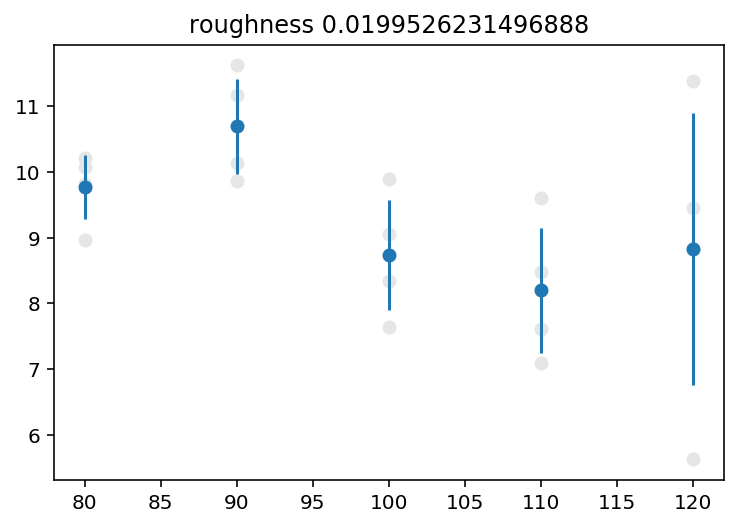

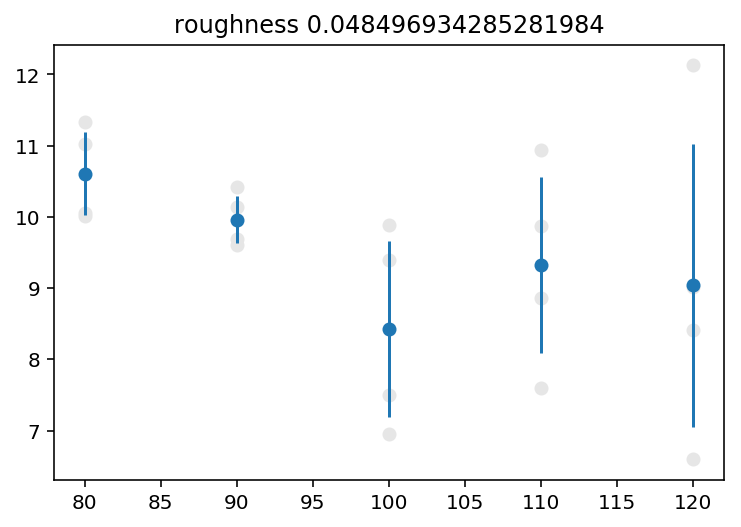

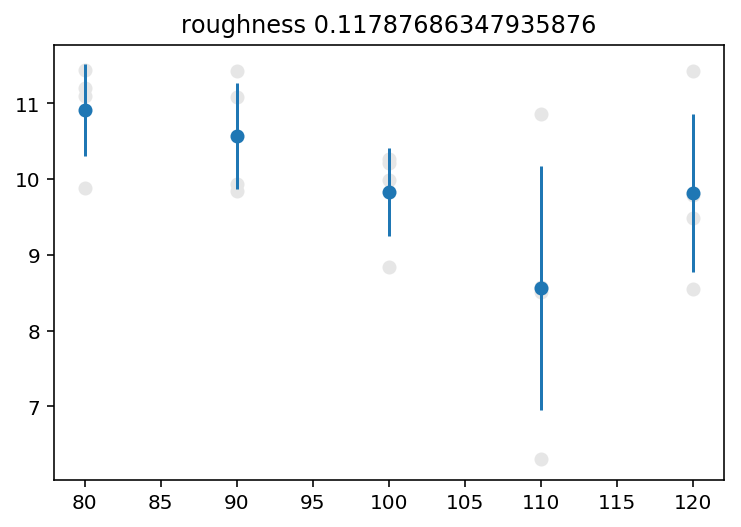

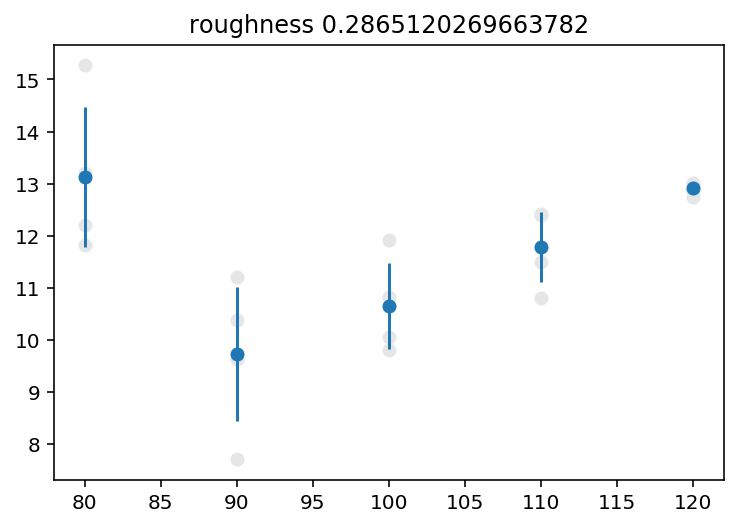

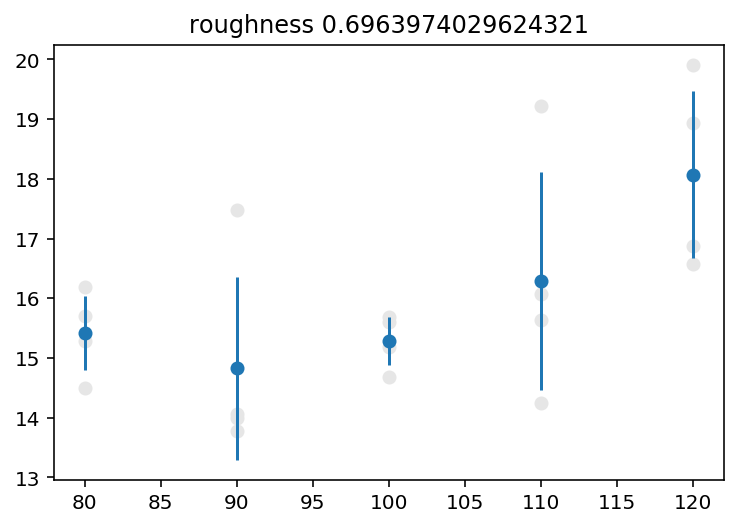

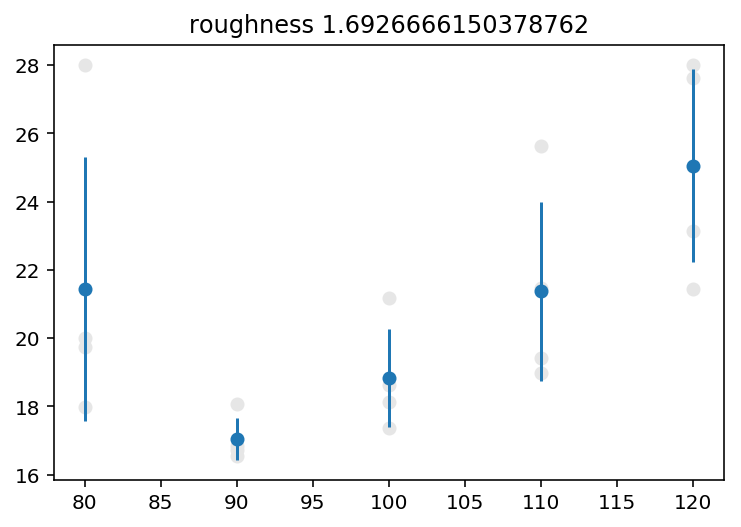

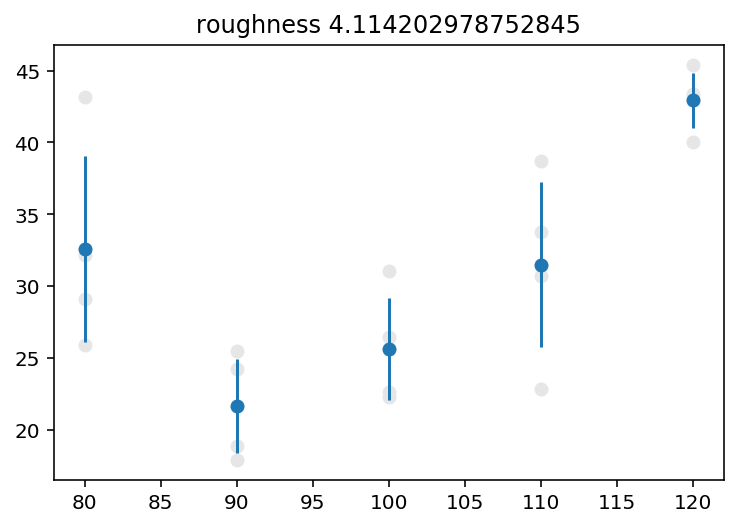

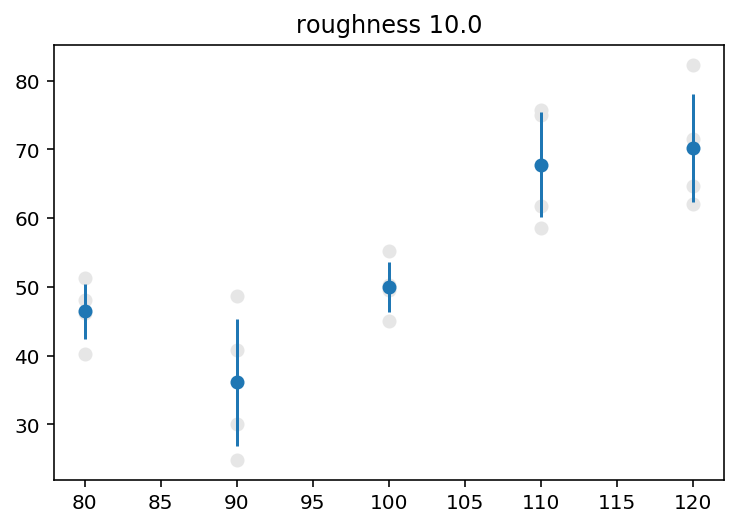

In [139]:
for i in range(len(roughnessMatrix)):
    allScores = [ r for row in roughnessMatrix[i] for r in row]
    ranges = [aiR for aiR in aiScores for i in range(reps)]
    plt.scatter(ranges,allScores,c=[.9,.9,.9])
    plotCategoricalMeans(ranges,allScores)
    plt.title("roughness %s" % roughnesses[i])
    plt.show()

Text(0,0.5,'roughness')

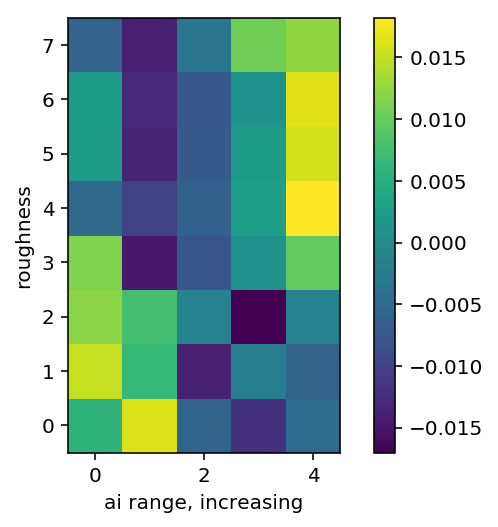

In [141]:
roughnessImg = [ [np.mean(row) for row in block] for block in roughnessMatrix ]
#standardize rows:
for i in range(len(roughnessImg)):
    r = np.array(roughnessImg[i])
    m = np.mean(r)
    sd = np.std(r)
    r = (r - m) / sd
    r = list(r)
    roughnessImg[i] = r
np.shape(roughnessImg)
roughnessImg = np.array(roughnessImg) / 100 
plt.imshow(roughnessImg,origin='lower-left')
plt.colorbar()
plt.xlabel("ai range, increasing")
plt.ylabel("roughness")

## roughness vs range

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True
AVG_SPEED = .02

nAgents = 4
nTeams = 2
nDims = 20
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = teamDimensions(nDims,nTeams)

pComm = 0.2 # np.linspace(0,.5,10)

steps = 40
reps = 16 # 10 #$40 #5

aiScores = np.linspace(80,120,5)
aiRange = 0
aiRanges = np.linspace(0,60,5)
aiScore = 100

meetingTimes = 10000 

roughnesses = [0,.05,1,5] #np.linspace(1,5,3)
roughnessMatrix = []
ROUGHNESS = 10
roughnesses = np.logspace(-1.7,1,4,base=10)
for ROUGHNESS in roughnesses:#,8,16,32,64]:
    agentTeams = specializedTeams(nAgents,nTeams)
    teamDims = teamDimensions(nDims,nTeams)
    scoresForAI = []
    for aiRange in aiRanges:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            scoresForAI.append([t.getBestCurrentScore() for t in allTeams])
    roughnessMatrix.append(scoresForAI)
    print("completed one")
print("time to complete: "+str(timer.time()-t0))
chaching()

completed one


In [ ]:
for i in range(len(roughnessMatrix)):
    allScores = [ r for row in roughnessMatrix[i] for r in row]
    ranges = [aiR for aiR in aiRanges for i in range(reps)]
    plt.scatter(ranges,allScores,c=[.9,.9,.9])
    plotCategoricalMeans(ranges,allScores)
    plt.title("roughness %s" % roughnesses[i])
    plt.show()

# paths of agents

In [98]:
nDims = 2
nTeams = 1
nAgents = 4
aiScore = 120
aiRange = 50
steps = 200
pComm = 0
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = teamDimensions(nDims,nTeams)
t = teamWorkProcess(0)
a = t.agents[0]

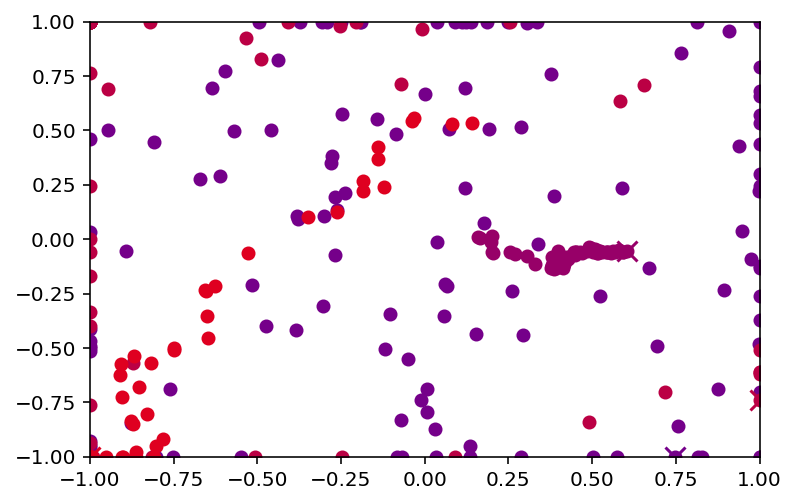

In [99]:
showPath(t.agents)

# Does number of local minima affect optimal kai score?
no

In [ ]:
a = 1

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComm = 0.2 # np.linspace(0,.5,10)

steps = 500
reps = 4 # 10 #$40 #5

aiScores = np.linspace(60,140,5)
aiRange = 0
# aiRanges = np.linspace(0,100,10)

meetingTimes = 10000 

ws = np.linspace(1,100,4)
scoreMatrix = []
for w_global in ws:
    scoresForAI = []
    for aiScore in aiScores:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            scoresForAI.append(np.mean([t.getBestScore() for t in allTeams]))
    scoreMatrix.append(scoresForAI)
    print("completed one")
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
roughnessImg = scoreMatrix # [ [np.mean(row) for row in block] for block in scoreMatrix ]
np.shape(roughnessImg)
roughnessImg = np.array(roughnessImg) / 100 
plt.imshow(roughnessImg,origin='lower-left')
plt.colorbar()
plt.xlabel("ai score, increasing")
plt.ylabel("number of local minima")

# Does the number of dimensions affect optimal kai score?

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComm = 0.2 # np.linspace(0,.5,10)
nDimsChoices = [int(n) for n in np.linspace(5,200,5)]
nAgents = 10
nTeams = 5



steps = 100
reps = 4 # 10 #$40 #5

aiScores = np.linspace(60,140,5)
aiRange = 0
# aiRanges = np.linspace(0,100,10)

meetingTimes = 10000 

scoreMatrix = []
for nDims in nDimsChoices:
    teamDims = teamDimensions(nDims,nTeams)
    agentTeams = specializedTeams(nAgents,nTeams)
    scores = []
    for aiScore in aiScores:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            scores.append(np.mean([t.getBestScore() for t in allTeams]))
    scoreMatrix.append(scores)
    print("completed one")
print("time to complete: "+str(timer.time()-t0))
chaching()

In [ ]:
roughnessImg = scoreMatrix # [ [np.mean(row) for row in block] for block in scoreMatrix ]
np.shape(roughnessImg)
roughnessImg = np.array(roughnessImg) / 100 
plt.imshow(roughnessImg,origin='lower-left')
plt.colorbar()
plt.xlabel("ai score, increasing")
plt.ylabel("n dimensions")

# Does the difficulty of communicating long distance affect composition requirements?

In [ ]:
#tune meeting cost

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True

pComm = 0.2 # np.linspace(0,.5,10)
# nAgents = 10
# nTeams = 5
#     teamDims = teamDimensions(nDims,nTeams)
#     agentTeams = specializedTeams(nAgents,nTeams)

steps = 100
reps = 8 # 10 #$40 #5

aiScores = np.linspace(80,115,5)
aiRanges = np.linspace(0,30,4)
# aiRanges = np.linspace(0,100,10)

meetingTimes = 30 

scoreMatrix = []
for aiRange in aiRanges:

    scores = []
    for aiScore in aiScores:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            scores.append([t.getBestCurrentScore() for t in allTeams])
    scoreMatrix.append(scores)
    print("completed one")
print("time to complete: "+str(timer.time()-t0))
# chaching()

In [ ]:
for j in range(len(aiRanges)):
    oneRange = np.array(scoreMatrix[j]) #one range, all avgs, all repeats
    scoresForAi = []
    for i in range(len(aiScores)):
        scoresForAi.append(np.mean(oneRange[i,:]))
    plt.plot(aiScores,scoresForAi, label='range: %s' %aiRanges[j])
    plotCategoricalMeans(aiScores,scoresForAi)
#     plt.scatter(aiScores,oneRange[:,i],label='%s')
plt.legend()

In [ ]:
roughnessImg = [ [np.mean(row) for row in block] for block in scoreMatrix ]
np.shape(roughnessImg)
roughnessImg = np.array(roughnessImg) / 100 
plt.imshow(roughnessImg,origin='lower-left')
plt.colorbar()
plt.xlabel("ai score, increasing")
plt.ylabel("ai range")

# Organic composition

In [428]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComm = .2 # np.linspace(0,.5,10)
nAgents = 4
nTeams = 4
nDims = 16
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

steps = 20
reps = 16 # 10 #$40 #5

aiScore = None
aiRange = None
# aiRanges = np.linspace(0,100,10)

meetingTimes = .10

allTeams = []
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 4)
    allTeams = pool.map(teamWorkProcess, range(reps))
# chaching()

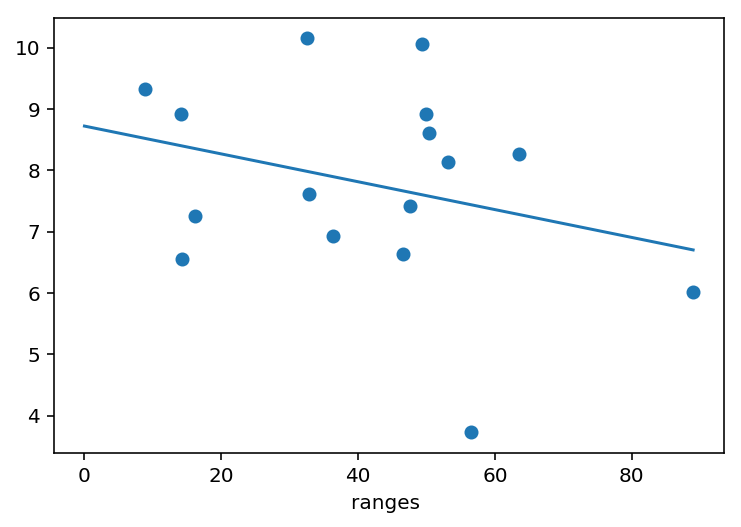

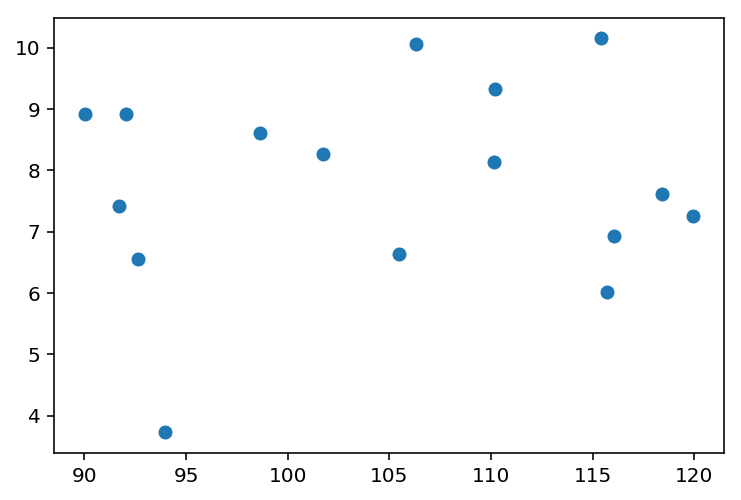

In [429]:
scores = []
means = []
ranges = []
es = []
for t in allTeams:
    scores.append(t.getBestCurrentScore())
    means.append(np.mean([a.kai.KAI for a in t.agents]))
    ranges.append(t.dAI)
    es.append(np.mean([a.kai.E for a in t.agents]))
plt.scatter(ranges,scores)
plt.xlabel("ranges ")
p = np.polyfit(ranges,scores,1)
z = np.poly1d(p)
x1 = np.linspace(0,max(ranges),100)
plt.plot(x1,z(x1))
plt.show()
plt.scatter(means,scores)

# Track the team's communication "effort"

In [216]:
#watch them move real quick
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False
# constructor = Crescent

pComm = 0 # np.linspace(0,.5,10)
nAgents = 3
nTeams = 1
nDims = 2
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

steps = 100
reps = 1 # 10 #$40 #5

aiRange = 0
aiScore = 150
# aiScore = 100
# aiRanges = np.linspace(0,100,5)

meetingTimes = .1 

team = teamWorkProcess(1)
# chaching()

(0, 3)

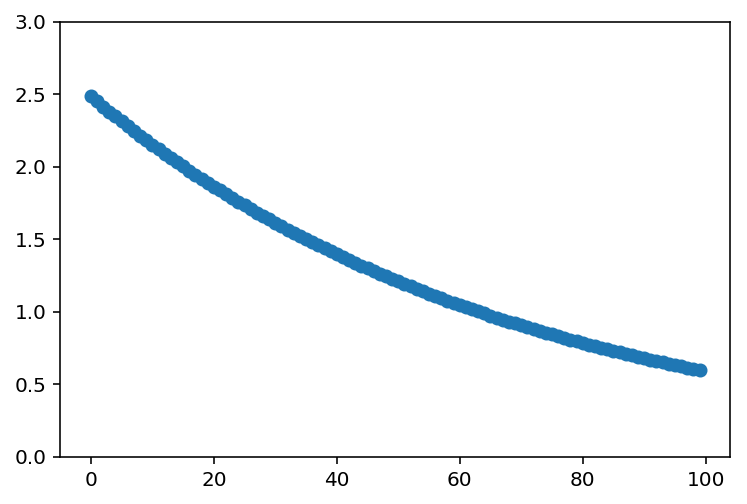

In [220]:
time= range(steps)
decay = [a0.startTemp *a0.decay**n  for n in time]
plt.scatter(time,decay)
plt.ylim([0,3])

50


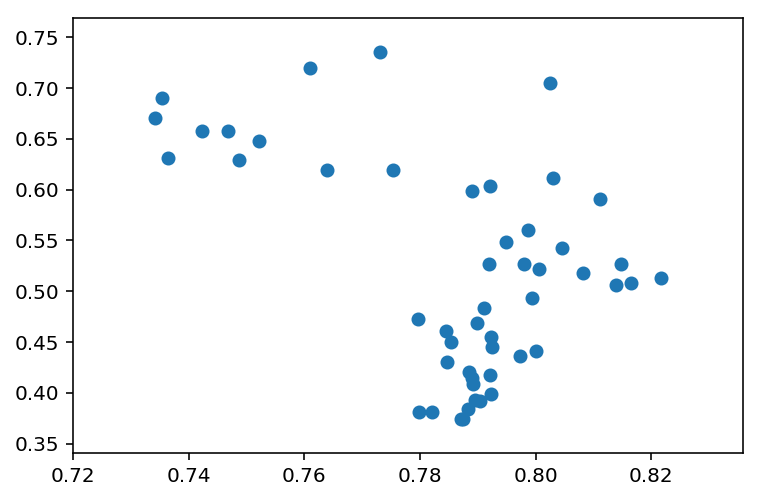

In [217]:
a0 = team.agents[1]
mem = a0.memory
print(len(mem))
xs = [m.r[0] for m in mem]
ys = [m.r[1] for m in mem]
plt.scatter(xs,ys)

In [326]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComm = 0.2 # np.linspace(0,.5,10)
nAgents = 33
nTeams = 11
nDims = 20
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

steps = 100
reps = 4 # 10 #$40 #5

aiScores = np.linspace(60,140,5)
aiRange = 10
# aiScore = 100
# aiRanges = np.linspace(0,100,5)

meetingTimes = 20 

teams = []
for aiScore in aiScores:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        teams.append(allTeams)
# chaching()

(0, 0.05)

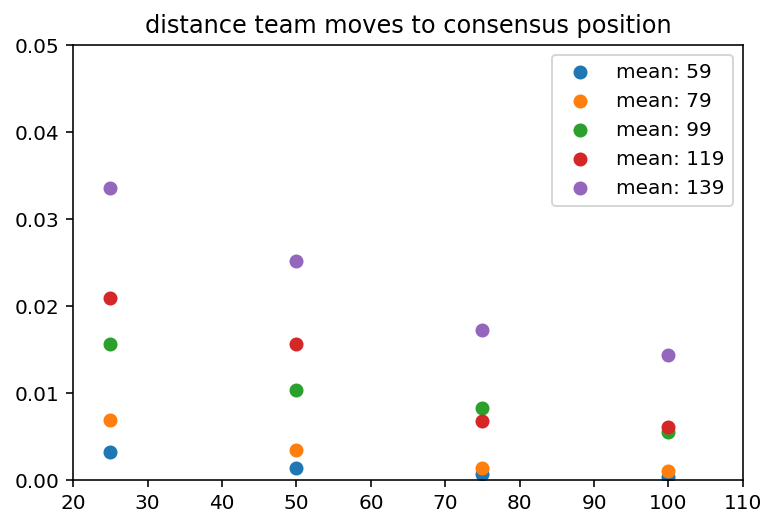

In [330]:
for t in teams:
    t0 = t[0]
    aiScore = np.mean([a.kai.KAI for a in t0.agents])
    md = t0.meetingDistances
    plt.scatter(np.linspace(0,steps,len(md)),md,label="mean: "+str(int(aiScore)))
plt.legend()
T = plt.title("distance team moves to consensus position")
plt.xlim([20,110])
plt.ylim(0,.05)

### now for team diversity

In [331]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

pComm = 0.2 # np.linspace(0,.5,10)
nAgents = 33
nTeams = 11
nDims = 20
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

steps = 100
reps = 1 # 10 #$40 #5

aiScore = 100# np.linspace(60,140,5)
aiRange = np.linspace(5,100,5)
# aiScore = 100
# aiRanges = np.linspace(0,100,5)

meetingTimes = 20 

teams = []
for aiRange in aiRanges:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        teams.append(allTeams)
# chaching()

(0, 0.1)

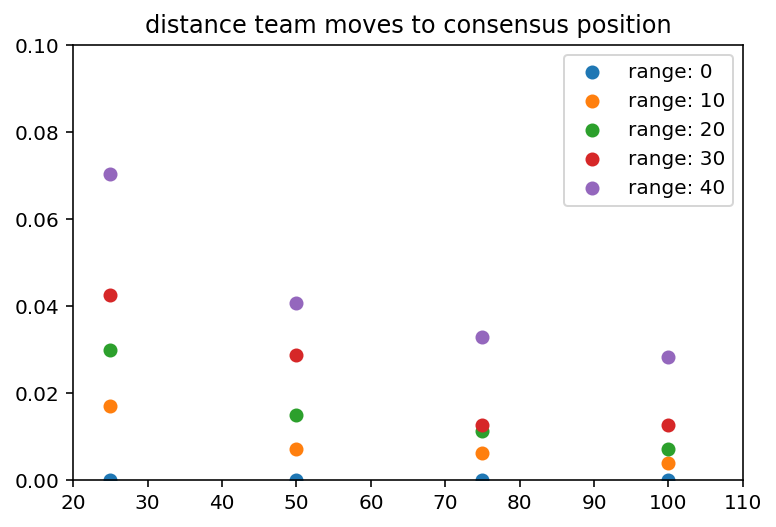

In [340]:
for t in teams:
    t0 = t[1]
    aiRange = np.max([a.kai.KAI for a in t0.agents])-np.min([a.kai.KAI for a in t0.agents])
    md = t0.meetingDistances
    plt.scatter(np.linspace(0,steps,len(md)),md,label="range: "+str(int(aiRange)))
plt.legend()
T = plt.title("distance team moves to consensus position")
plt.xlim([20,110])
plt.ylim(0,.1)

# check effect of team diversity

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True

pComms = [0.2]# np.linspace(0,.3,10)
pComm = 0.2

steps = 500
reps = 4 # 

aiScoresMeans = [100]#np.linspace(80,120,3)
aiScore = 100
aiRanges = np.linspace(0,30,5)

meetingTimes = steps #have one meeting at the end

allTeamObjects = []
i = 0
for aiRange in aiRanges:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i +=1
        print('completed %s of %s' % (i, len(aiRanges)))
        for team in allTeams:
            allTeamObjects.append(team)
# allTeams = [t for tl in allTeamObjects for t in tl]
print("time to complete: "+str(timer.time()-t0))
allTeams = allTeamObjects
chaching()

[19.219252063129133,
 20.41498551717507,
 20.145001161329454,
 21.841363765566086,
 19.898916344727134]

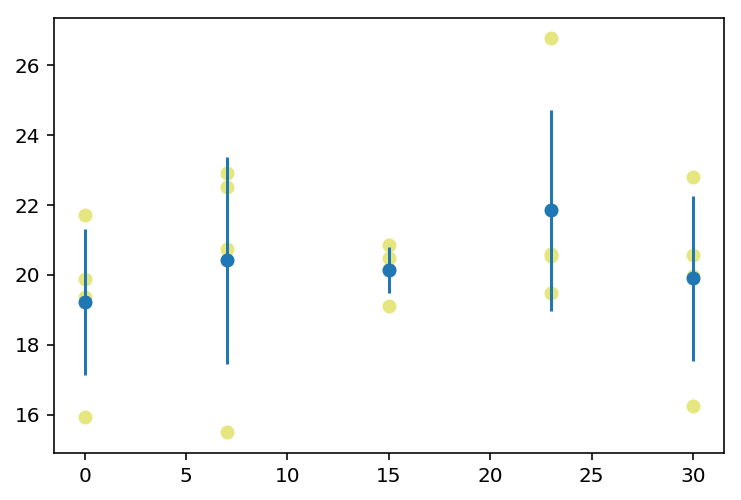

In [273]:
allScores = [t.getBestScore() for t in allTeamObjects]
ranges = [t.dAI for t in allTeamObjects]
plt.scatter(ranges,allScores, c=[.9,.9,.5])
plotCategoricalMeans(ranges,allScores)

[21.631575486353597,
 19.958590004919035,
 23.84123420964939,
 26.206032302994355,
 23.959720264804403,
 26.452701892435506,
 26.02150763622343,
 26.441215761821965,
 28.02892161960603,
 25.143170403074123]

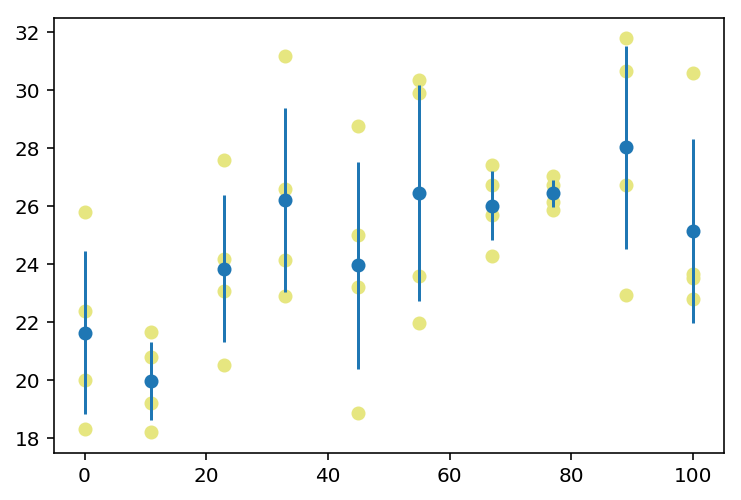

In [251]:
allScores = [t.getBestScore() for t in allTeamObjects]
ranges = [t.dAI for t in allTeamObjects]
plt.scatter(ranges,allScores, c=[.9,.9,.5])
plotCategoricalMeans(ranges,allScores)

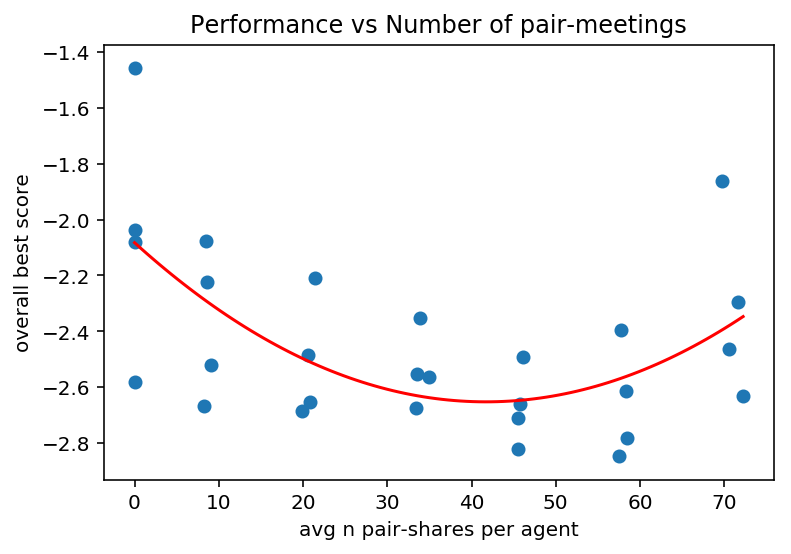

In [236]:
x = np.array([t.nMeetings / 33 for t in bigTeamSet])
yr = np.array([t.getBestScore() for t in bigTeamSet])
# xcat = [round(i*2,-1)/2 for i in x]
plt.scatter(x,yr)
p = np.polyfit(x,yr,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='red')
plt.title('Performance vs Number of pair-meetings')
plt.xlabel("avg n pair-shares per agent")
plt.ylabel("overall best score")
t = str(timer.time())
# np.savetxt("./savedParams/"+t+".txt",[makeParamString()], fmt='%s')
# plt.savefig("./figs/pairwiseSharing_noReset_"+t+".pdf")

In [393]:
#bootstrapping for mean and sd of minimum point
bestNshares = []

allInd = range(len(bigTeamSet))
for i in range(1000):
    ind = np.random.choice(allInd,14)
    teams = [bigTeamSet[j] for j in ind]
    x = [t.nMeetings/33 for t in teams]
    y = [t.getBestScore() for t in teams]
    x1 = np.linspace(min(x),max(x),300)
    p = np.polyfit(x,y,2)
    z = np.poly1d(p)
    predicted = z(x1)
    bestNshares.append(x1[np.argmin(predicted)])
    
print("best n shares per agent:")
print("mean:" +str(np.mean(bestNshares)))
print("std: "+str(np.std(bestNshares)))

best n shares per agent:
mean:43.4431558731124
std: 9.50356733199722


## Sharing: when is the exact time that sharing is best?

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = False

# pComms = [0.2]# np.linspace(0,.3,20)
pComm = 0.2

steps = 500#500
reps = 4 #16

aiScore = 100
aiRange = 0
# meetingTimes = steps #have one meeting at the end

teamsCommTiming = []
nTimeDivisions = 10

for i in range(nTimeDivisions):
    pCommTime = np.zeros(nTimeDivisions)
    pCommTime[i] = 1
    allTeamObjects = []
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        for team in allTeams:
            allTeamObjects.append(team)
    teamsCommTiming.append(allTeamObjects)
chaching()
print("time to complete: "+str(timer.time()-t0))

In [256]:
# teamsCommTiming1and2 = cp(allTeamsCommTiming)
times2 = [i for i in range(nTimeDivisions) for j in range(reps)]

In [700]:
# allTeamsCommTiming = []
# for row in range(nTimeDivisions):
#     allTeamsCommTiming.append(np.concatenate([teamsCommTiming[row],teamsCommTiming1and2[row]]))
# np.shape(allTeamsCommTiming)

(10, 24)

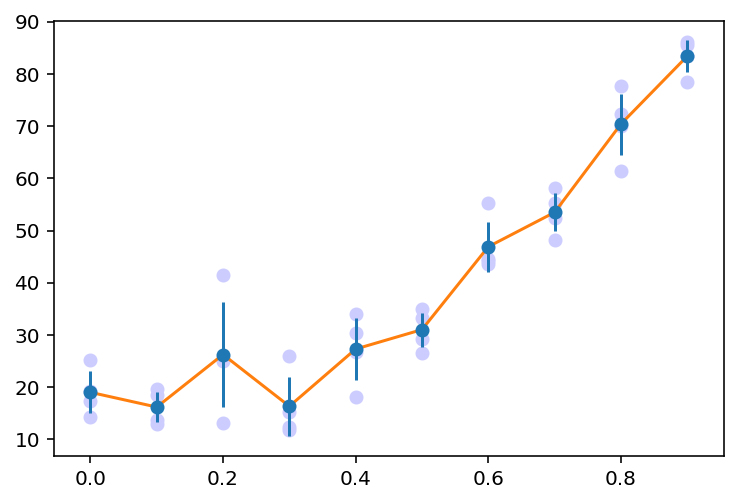

In [257]:
scoresAtTiming = []
scores1 = []
times1=[]
scoresAtTimes = []
for i in range(nTimeDivisions):
    theseTeams = teamsCommTiming[i]
    scoresAtTiming.append(np.mean([t.getBestScore() for t in theseTeams]))
    timeScores = []
    for t in theseTeams:
        scores1.append(t.getBestScore())
        times1.append(np.argmax(t.shareHistory))
        timeScores.append(t.getBestScore())
    scoresAtTimes.append(timeScores)
plt.scatter(np.array(times2)/10,scores1, c=[.8,.8,1])    
#     t = teamsCommTiming[i][0]
#     print(t.shareHistory)
meanScores = plotCategoricalMeans(np.array(times2)/10,scores1)
plt.plot(np.arange(10)/10,meanScores)
# plt.savefig("./timingOfSharing_vs_performance_24reps.pdf")


In [908]:
t = allTeamsCommTiming[0][0]
GOOD_SOLN = t.getBestSolution()


In [149]:
stat, p = scipy.stats.ttest_ind(scoresAtTimes[2],scoresAtTimes[8])
print("significance: p= "+str(p))
#anova test


NameError: name 'scoresAtTimes' is not defined

# check effect of team diversity

In [258]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True

pComms = [0.2]# np.linspace(0,.3,10)
pComm = 0.2

steps = 500
reps = 4 # 10 #$40 #5

aiScores = np.linspace(80,120,5)
# aiScore = 100
# aiRanges = np.linspace(0,100,10)
aiRange = 0

meetingTimes = steps #have one meeting at the end

allTeamObjects = []
allR = []
allMeans = []
for ROUGHNESS in np.linspace(0,.025, 3):
    for aiScore in aiScores:   
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))
            print('moving on')
            for team in allTeams:
                allTeamObjects.append(team)
                allR.append(ROUGHNESS)
                allMeans.append(allMeans)
    # allTeams = [t for tl in allTeamObjects for t in tl]
print("time to complete: "+str(timer.time()-t0))
chaching()

NameError: name 'aiScores' is not defined

[21.631575486353597,
 19.958590004919035,
 23.84123420964939,
 26.206032302994355,
 23.959720264804403,
 26.452701892435506,
 26.02150763622343,
 26.441215761821965,
 28.02892161960603,
 25.143170403074123]

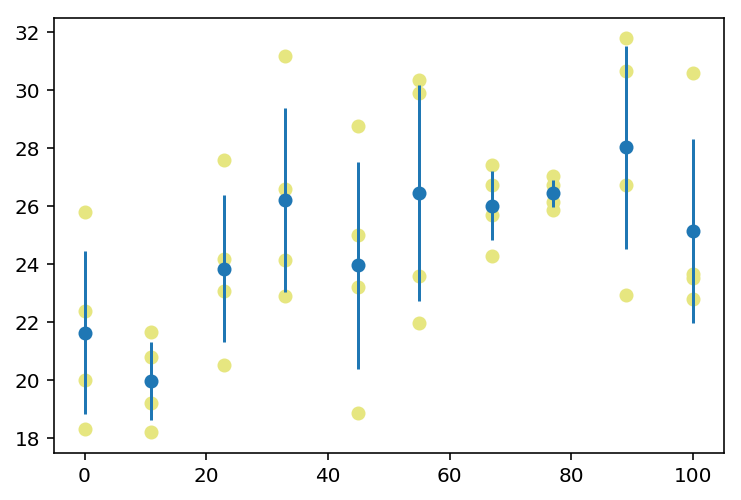

In [251]:
allScores = [t.getBestScore() for t in allTeamObjects]
ranges = [t.dAI for t in allTeamObjects]
plt.scatter(ranges,allScores, c=[.9,.9,.5])
plotCategoricalMeans(ranges,allScores)

## Simple Sharing: does it change outcome? no

## timing of team meetings

In [160]:
t0 = timer.time()
resetDefaultParameters()
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)
curatedTeams = False
complexSharing = True

pComm = 0.2
steps = 500#500
reps = 4 #16

aiScore = 100
aiRange = 0
# meetingTimes = steps #have one meeting at the end

teamsCommTiming = []

meetingTimes = 20
meetingChoices = np.linspace(1,steps,5)

for singleMeeting in meetingChoices:#(10):#nTimeDivisions):
    pCommTime = np.ones(nTimeDivisions)
#     pCommTime[i] = 1
#     startHavingMeetings = float(i)/sections
    allTeamObjects = []
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        for team in allTeams:
            allTeamObjects.append(team)
    teamsCommTiming.append(allTeamObjects)
chaching()
print("time to complete: "+str(timer.time()-t0))

time to complete: 200.64019918441772


Text(0.5,1,'If you get 1 team meeting, when should it be?')

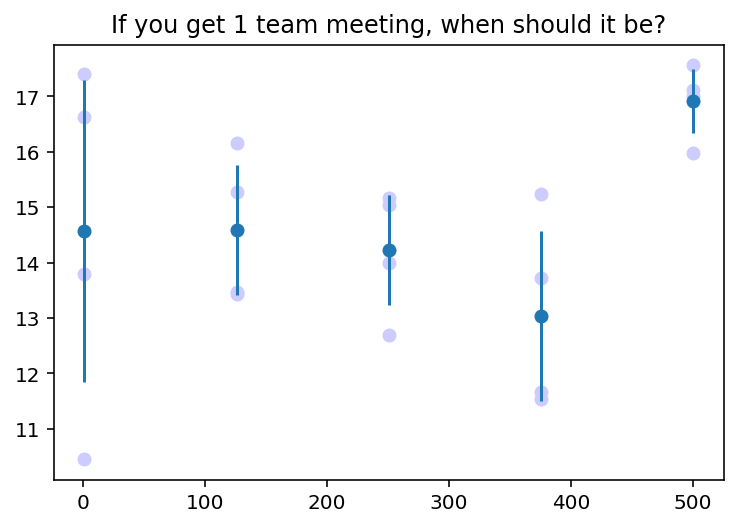

In [161]:

times3 = [s for s in meetingChoices for i in range(reps)]
len(times3)
teams = [t for a in teamsCommTiming for t in a]
len(teams)
scores = [t.getBestScore() for t in teams]
plt.scatter(times3,scores, c=[.8,.8,1])    

meanScores = plotCategoricalMeans(np.array(times3),scores)
plt.title("If you get 1 team meeting, when should it be?")

In [170]:
scoresGrouped = [[t.getBestScore() for t in teams] for teams in teamsCommTiming]
stat, p = scipy.stats.ttest_ind(scoresGrouped[4],scoresGrouped[3])
print(p)

0.006435614267381307


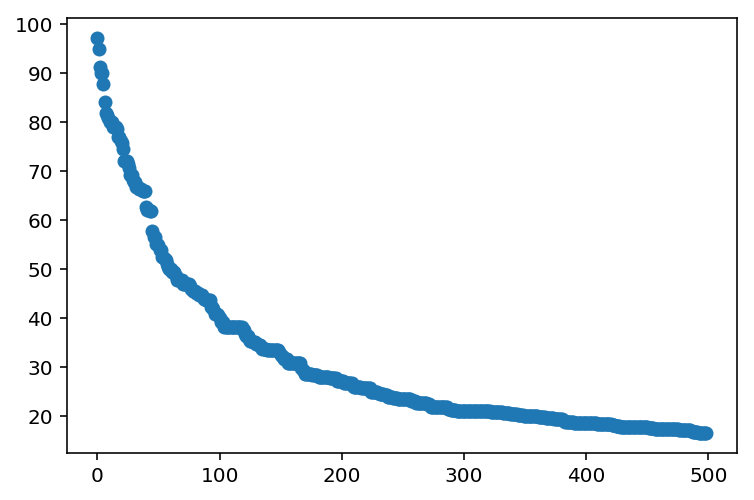

In [174]:
t0 = teamsCommTiming[0][0]
plt.scatter(range(len(t0.scoreHistory)),t0.scoreHistory)

## Curated teams have team composition mirroring superteam

In [893]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True

pComm = 0.2
aiScore = 100
aiRanges = [0]# np.linspace(0,90,10)

reps = 4 # 10 #$40 #5
steps = 500
testConvexity = []
i = 0
for aiRange in aiRanges:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiRanges)))
        for team in allTeams:
            testConvexity.append(team)
print("time to complete: "+str(timer.time()-t0))
chaching()

completed 1 of 1
time to complete: 156.55819582939148


In [349]:
def getBestScoreAtTime(team,t):
    # t is fraction of time in simulation. this is approximate
    scores = []
    for a in team.agents:
        ml = len(a.memory)
        memorySubset = a.memory[0:int(ml*t)]
        scores.append(np.min([m.score for m in memorySubset]))
    return min(scores)

In [350]:
# allTeamObjects1 = allTeamObjects
# for t in allTeamObjects:
#     allTeamObjects1.append(t)

In [394]:
tMeans = []
tSds = []
tScores = [] 
tRanges = []
tMeetings = []
bestScoresAtFraction = []
so = []
rg = []
e = []
for t in allTeamObjects:
    if t.getBestScore()>-2: continue
    kais = [a.kai.KAI for a in t.agents]
    tMeans.append(np.mean(kais))
    tRanges.append(np.max(kais)-np.min(kais))
    
    tSds.append(np.std(kais))
    tScores.append(t.getBestScore())
    tMeetings.append(t.nMeetings)
    bestScoresAtFraction.append(getBestScoreAtTime(t,.25))
    
    sos = [a.kai.SO for a in t.agents]
    so.append(np.mean(sos))
    
    es = [a.kai.E for a in t.agents]
    e.append(np.mean(es))
    
    rgs = [a.kai.RG for a in t.agents]
    rg.append(np.mean(rgs))

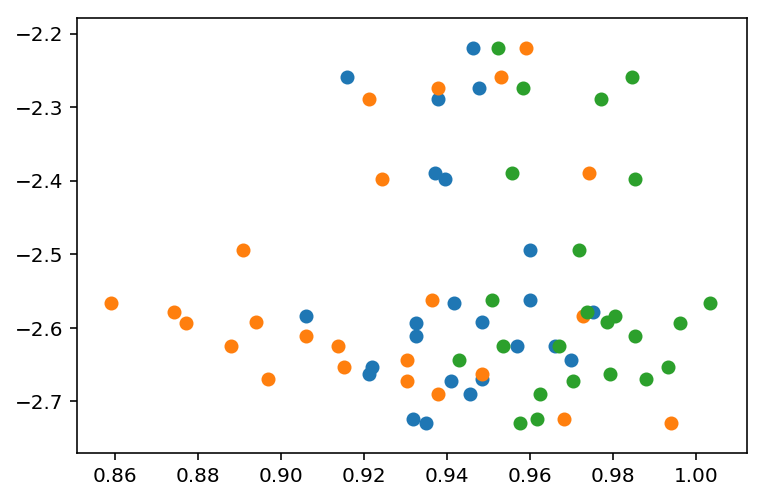

In [405]:
# any trends for subscores? not really
plt.scatter(np.array(rg)/40,tScores)
plt.scatter(np.array(e)/20,tScores)
plt.scatter(np.array(so)/45,tScores)

10/10/18 Question of the day:
# What if all agents have same speed?
Then we might see other KAI characteristics come out

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True
UNIFORM_SPEED = True

pComm = 0.2
aiScores = np.linspace(50,150,5)
aiRange = None # np.linspace(0,90,10)

reps = 8 # 10 #$40 #5
steps = 100
uniSpeed = []
i = 0
for aiScore in aiScores:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            uniSpeed.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True
UNIFORM_SPEED = True

pComm = 0.2
aiScores = np.linspace(50,150,5)
aiRange = None # np.linspace(0,90,10)

reps = 8 # 10 #$40 #5
steps = 100
uniSpeed = []
i = 0
for aiScore in aiScores:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            uniSpeed.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

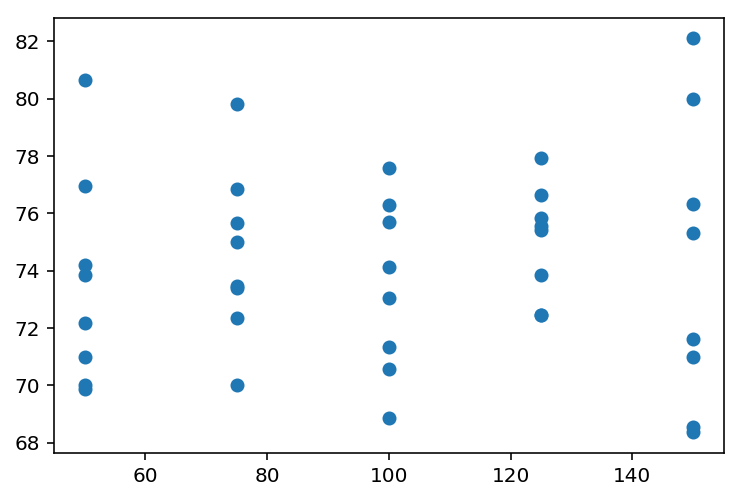

In [39]:
teamScores = [t.getBestScore() for t in uniSpeed]
aiAll = [kai for kai in aiScores for i in range(reps)]
# teamScores
plt.scatter(aiAll,teamScores)

Question of the day 10/11/18
## How do agents behave in non-convex domains?
(Sharing, best kai)

result: there doesn't seem to be an effect of range on performance
for avg score, extremes might outperform slightly? (confirm this?)

In [977]:
crescentFs = generateFunctionsNdims(nDims)
crescentGs = generateConstraints(2,nDims)

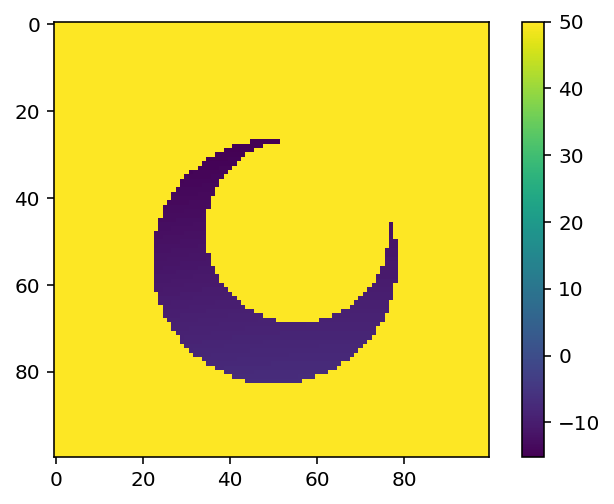

KeyboardInterrupt: 

In [1138]:
#check domain shapes:
size = 100
x1 = np.linspace(-1,1,size)
x2 = np.linspace(-1,1,size)
y = np.zeros([size,size])
d1 = 0
for d2 in range(1,5):
    for i in range(len(x1)):
        for j in range(len(x2)):
            x = np.zeros(nDims)
            x[d1] = x1[i]
            x[d2] = x2[j]
            yi = evalX(crescentFs,x, crescentGs)
            yi = min(yi,50)
            y[i,j] = yi

    np.shape(y)
    plt.imshow(y)
    plt.colorbar()
    plt.show()

In [1141]:
#find feasible locations:
x0 = np.random.uniform(-1,1,nDims)
count = 0
a = Crescent()
while a.fr(x0)>1E10:
    x0 = np.random.uniform(-.3,.3,nDims)
    count+=1
    if count>=100000:
        print('couldnt find any')
        break
count

14

In [1206]:
# print(x0)
# print(evalX(crescentFs,x0,crescentGs))
# donutFs = cp(crescentFs)
# donutGs = cp(crescentGs)

[-0.0272936  -0.09417598  0.00135436 -0.16317621 -0.02956528 -0.29843918
  0.03453229  0.02462802  0.26129769 -0.29794646 -0.12180457 -0.00637034
 -0.19384924 -0.13969082  0.20739046  0.09357877 -0.11812556 -0.23666002
 -0.0661105  -0.04988136]
-12.775903197763277


In [1143]:
resetDefaultParameters()
constructor = Crescent
nAgents = 2
nDims = 20
nTeams = 1
RG_STRENGTH = 0
SO_STRENGTH = 0
#flat or specialized?
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = np.ones([nTeams,nDims])

startPositions = [x0 for i in range(nAgents)]

pComm = 0
AVG_TEMP = 3
aiScore = 150
AVG_SPEED = 0.01
steps = 100

t = teamWorkProcess(0) 
path = t.agents[0].memory

29

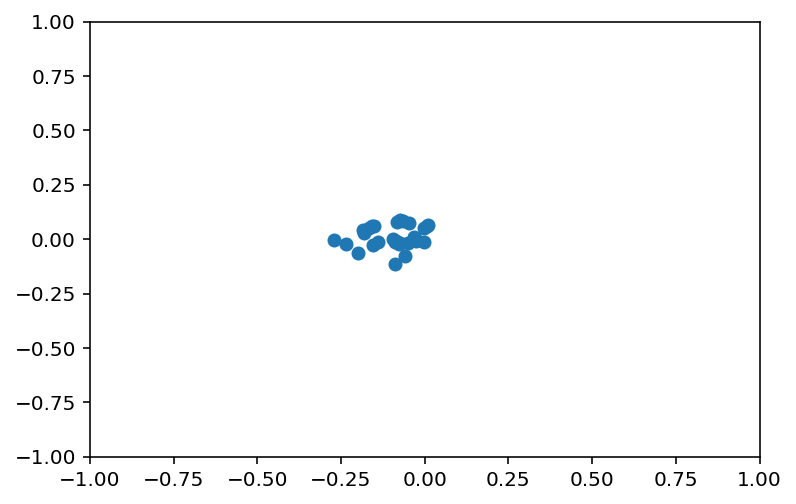

In [1144]:
allLocations = np.array([m.r for m in path])
startChoices = allLocations[0:int(len(allLocations)/3)]
plt.scatter(startChoices[:,1],startChoices[:,2])
plt.xlim([-1,1])
plt.ylim([-1,1])
len(startChoices)

In [1145]:
print(x0)
t.agents[0].memory[0].r

[-0.0272936  -0.09417598  0.00135436 -0.16317621 -0.02956528 -0.29843918
  0.03453229  0.02462802  0.26129769 -0.29794646 -0.12180457 -0.00637034
 -0.19384924 -0.13969082  0.20739046  0.09357877 -0.11812556 -0.23666002
 -0.0661105  -0.04988136]


array([-0.0272936 , -0.09417598,  0.00135436, -0.16317621, -0.02956528,
       -0.29843918,  0.03453229,  0.02462802,  0.26129769, -0.29794646,
       -0.12180457, -0.00637034, -0.19384924, -0.13969082,  0.20739046,
        0.09357877, -0.11812556, -0.23666002, -0.0661105 , -0.04988136])

In [1195]:
# # a = t.agents[0]
# [a.fr(c) for c in startChoices]

In [1204]:
t0 = timer.time()
resetDefaultParameters()
constructor = Crescent
nAgents = 20
nDims = 20
nTeams = 4
#flat or specialized?
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = np.ones([nTeams,nDims])

curatedTeams = True
UNIFORM_SPEED = True
constructor = Crescent
startPositions = [startChoices[np.random.choice(range(len(startChoices)))] for i in range(nAgents)]

RG_STRENGTH = 10
SO_STRENGTH = 10
AVG_TEMP = 3
SD_TEMP = 2

pComm = 0.2
aiScores = np.linspace(60,140,5)
aiRange = 0 
# aiScore = 100
# aiRanges = np.linspace(0,100,5)

reps = 4 # 10 #$40 #5
steps = 100
donutScores = []
i = 0
for aiScore in aiScores:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            donutScores.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

completed 1 of 5
completed 2 of 5
completed 3 of 5
completed 4 of 5
completed 5 of 5
time to complete: 26.008881092071533


Process ForkPoolWorker-1216:
Process ForkPoolWorker-1215:
Process ForkPoolWorker-1217:
Process ForkPoolWorker-1213:
Process ForkPoolWorker-1211:
Process ForkPoolWorker-1212:
Process ForkPoolWorker-1209:
Process ForkPoolWorker-1210:
Process ForkPoolWorker-1208:
Process ForkPoolWorker-1214:
Process ForkPoolWorker-1206:
Process ForkPoolWorker-1199:
Process ForkPoolWorker-1207:
Process ForkPoolWorker-1203:
Process ForkPoolWorker-1204:
Process ForkPoolWorker-1198:
Process ForkPoolWorker-1200:
Process ForkPoolWorker-1205:
Process ForkPoolWorker-1202:
Process ForkPoolWorker-1201:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rece

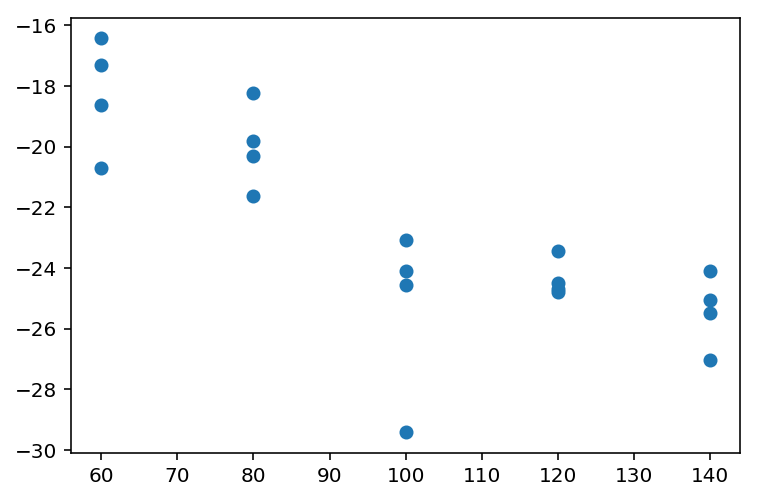

In [1205]:
teamScores = [t.getBestScore() for t in donutScores]
x = [kai for kai in aiScores for i in range(reps)]
# teamScores
plt.scatter(x,teamScores)

# How much sharing is useful in the donut domain?
answer: ideal pComm = 0.2 

In [1156]:
t0 = timer.time()
resetDefaultParameters()
constructor = Crescent
nAgents = 20
nDims = 20
nTeams = 4
#flat or specialized?
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = np.ones([nTeams,nDims])

curatedTeams = True
UNIFORM_SPEED = True
constructor = Crescent
startPositions = [startChoices[np.random.choice(range(len(startChoices)))] for i in range(nAgents)]

RG_STRENGTH = 30
SO_STRENGTH = 30
AVG_TEMP = 3
SD_TEMP = 2

pComms = np.linspace(0,.4,5)
# aiScores = np.linspace(50,150,5)
aiRange = None # np.linspace(0,90,10)
aiScore = 100
# aiRanges = np.linspace(0,100,5)

reps = 4 # 10 #$40 #5
steps = 100
donutScores = []
i = 0
for pComm in pComms:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            donutScores.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

completed 1 of 5
completed 2 of 5
completed 3 of 5
completed 4 of 5
completed 5 of 5
time to complete: 21.776336908340454


Process ForkPoolWorker-988:
Process ForkPoolWorker-974:
Process ForkPoolWorker-992:
Process ForkPoolWorker-982:
Process ForkPoolWorker-990:
Process ForkPoolWorker-978:
Process ForkPoolWorker-987:
Process ForkPoolWorker-977:
Process ForkPoolWorker-976:
Process ForkPoolWorker-979:
Process ForkPoolWorker-975:
Process ForkPoolWorker-985:
Process ForkPoolWorker-981:
Process ForkPoolWorker-991:
Process ForkPoolWorker-989:
Process ForkPoolWorker-993:
Process ForkPoolWorker-984:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-980:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _boot

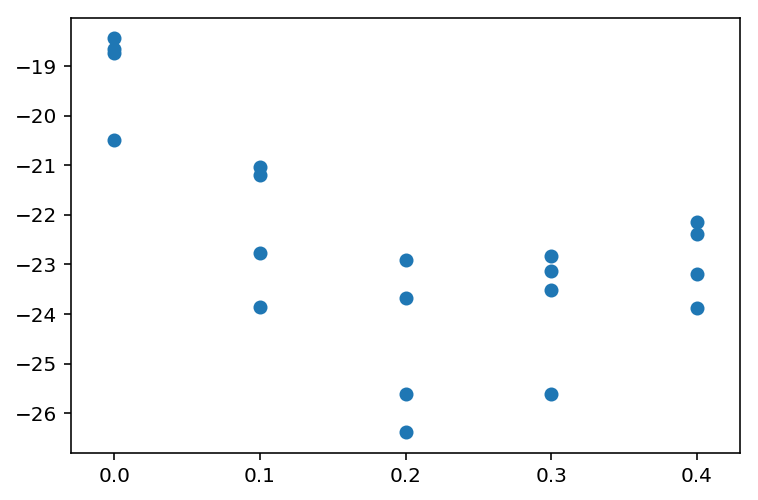

In [1159]:
teamScores = [t.getBestScore() for t in donutScores]
x = [pC for pC in pComms for i in range(reps)]
# teamScores
plt.scatter(x,teamScores)

# Now create a discontinuous domain

In [132]:
import multiprocessing

In [149]:
crescentFs = generateFunctionsNdims(nDims)
c1 = np.array([0.4 for i in range(nDims)])
c2 = np.zeros(nDims)
r = 0.3
g1 = generateConstraint2(1,r,c1,nDims)
g2 = generateConstraint2(1,r,c2,nDims)
crescentGs = [g1,g2]

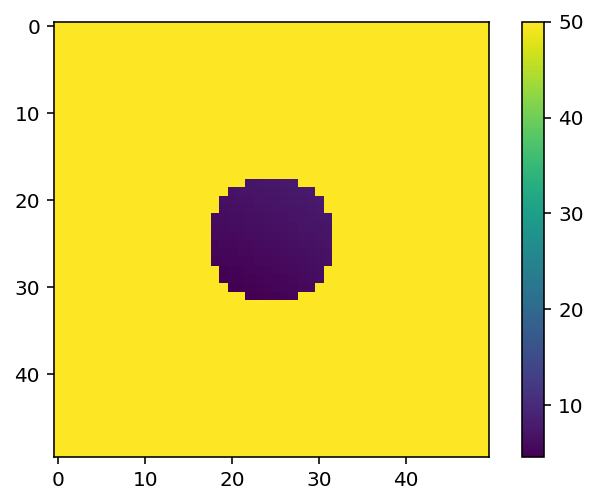

In [151]:
#check domain shapes:
size = 50
x1 = np.linspace(-1,1,size)
x2 = np.linspace(-1,1,size)
y = np.zeros([size,size])
d1 = 0
for d2 in range(1,2):
    for i in range(len(x1)):
        for j in range(len(x2)):
            x = np.zeros(nDims)
            x[d1] = x1[i]
            x[d2] = x2[j]
            yi = evalXpeacewise(crescentFs,x, crescentGs)
            yi = min(yi,50)
            y[i,j] = yi

    np.shape(y)
    plt.imshow(y)
    plt.colorbar()
    plt.show()

In [166]:
startChoices = []
for i in range(10):
    startChoices.append(c1 + np.random.uniform(-r**2,r**2,nDims))
    startChoices.append(c2 + np.random.uniform(-r**2,r**2,nDims))

In [167]:
evalXpeacewise(crescentFs,np.zeros(nDims),crescentGs)

6.2026000161525685

In [168]:
[evalXpeacewise(crescentFs,startChoices[i],crescentGs) for i in range(len(startChoices))]

[-3.9922320120396364,
 4.489748572552342,
 -3.975250253641171,
 6.0091193885266145,
 -3.2915049910839684,
 7.584574957697387,
 -5.876001364218659,
 5.3668725367326635,
 -3.6987854824958166,
 6.516076583011454,
 -3.1882928589821447,
 5.799650646118103,
 -4.7152105190038025,
 5.867710304829038,
 -4.893257566310167,
 4.934900557006916,
 -4.468113098236374,
 3.9370680452579876,
 -4.109969180671833,
 6.2396950408816885]

In [174]:
t0 = timer.time()
resetDefaultParameters()
constructor = PeaceWise
nAgents = 20
nDims = 20
nTeams = 4
#flat or specialized?
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = np.ones([nTeams,nDims])

curatedTeams = True
UNIFORM_SPEED = True
startPositions = [startChoices[np.random.choice(range(len(startChoices)))] for i in range(nAgents)]

RG_STRENGTH = 10
SO_STRENGTH = 10
AVG_TEMP = 3
SD_TEMP = 2

pComm = 0.2
aiScores = np.linspace(60,140,5)
aiRange = 0 
aiScore = 100
aiRanges = np.linspace(0,40,5)

reps = 8 # 10 #$40 #5
steps = 100
donutScores = []
i = 0
for aiRange in aiRanges:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            donutScores.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

completed 1 of 5
completed 2 of 5
completed 3 of 5
completed 4 of 5
completed 5 of 5
time to complete: 29.063986778259277


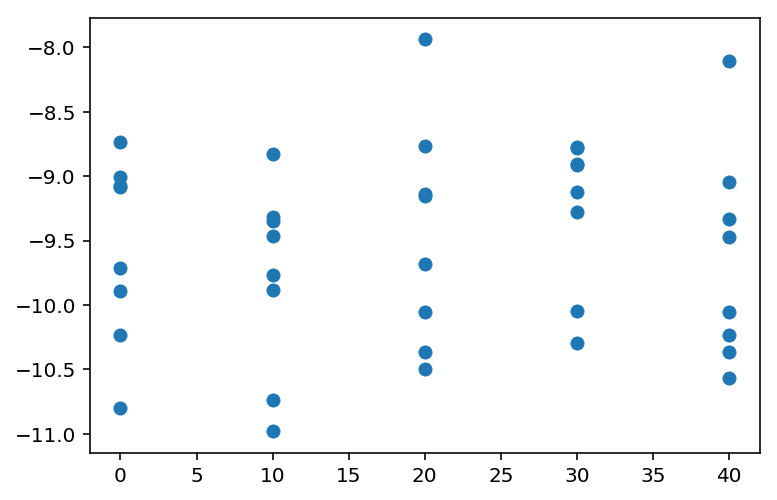

In [175]:
teamScores = [t.getBestScore() for t in donutScores]
x = [kai for kai in aiRanges for i in range(reps)]
# teamScores
plt.scatter(x,teamScores)

# Check sharing timing effect
Seems like team meetings hurt performance - for a flat team
How about for a specialized team

This is an interesting result. Flat teams are hurt by team meetings, but specialized teams benefit

In [ ]:
t0 = timer.time()
resetDefaultParameters()
nAgents = 20
nDims = 20
nTeams = 4
#flat or specialized?
agentTeams = specializedTeams(nAgents,nTeams)
teamDims = teamDimensions(nDims,nTeams) #np.ones([nTeams,nDims])

curatedTeams = True
UNIFORM_SPEED = True
constructor = Crescent

pComm = 0.2
# aiScores = np.linspace(50,150,5)
# aiRange = None # np.linspace(0,90,10)
aiScore = 100
aiRanges = np.linspace(0,70,5)

reps = 8 # 10 #$40 #5
steps = 200
meetingStartTime = []
meetingTimes = 20
starts = np.linspace(0,1,5)

i = 0
for startHavingMeetings in starts:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            meetingStartTime.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

0.0023251859787559756

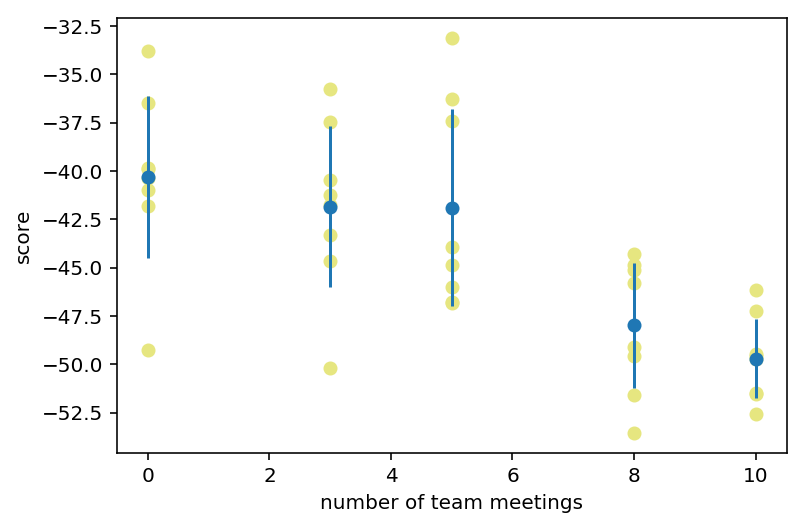

In [699]:
teamScores = [t.getBestScore() for t in meetingStartTime]
nMeetings = [t.nTeamMeetings/2 for t in meetingStartTime]
aiAll = [m for m in starts for i in range(reps)]
# teamScores
# plt.scatter(aiAll,teamScores)
# plt.show()
plt.scatter(nMeetings,teamScores, c=[.9,.9,.5])
means = plotCategoricalMeans(nMeetings,teamScores)
plt.xlabel("number of team meetings")
plt.ylabel("score")
pScore(teamScores[0:7],teamScores[0+8*3:7+8*3])

In [72]:
t0 = timer.time()
curatedTeams = True
UNIFORM_SPEED = True
constructor = Crescent

pComms = np.linspace(0,.3,5)
# aiScores = np.linspace(50,150,5)
# aiRange = None # np.linspace(0,90,10)
aiScore = 100
aiRanges = np.linspace(0,70,5)

reps = 4 # 10 #$40 #5
steps = 100
meetingStartTime = []
meetingTimes = 10000
# starts = np.linspace(0,1,5)

i = 0
for pComm in pComms:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        i+=1
        print('completed %s of %s' % (i , len(aiScores)))
        for team in allTeams:
            meetingStartTime.append(team)
print("time to complete: "+str(timer.time()-t0))
# chaching()

NameError: name 'multiprocessing' is not defined

Text(0,0.5,'score')

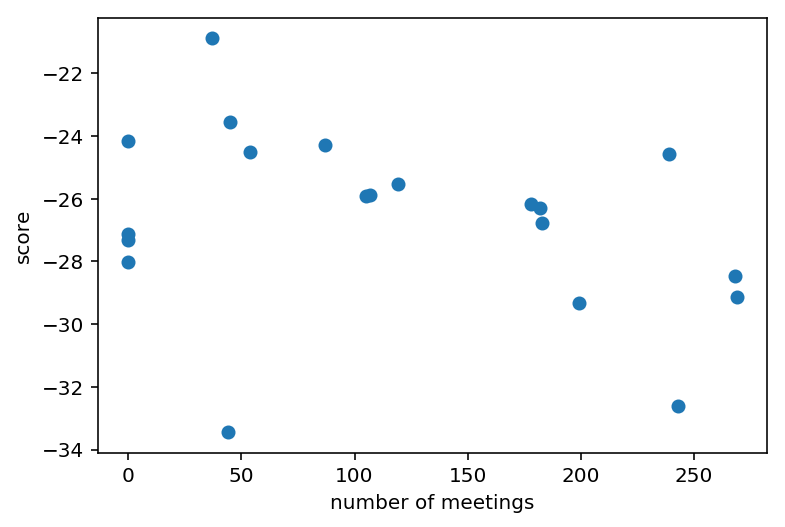

In [685]:
teamScores = [t.getBestScore() for t in meetingStartTime]
nMeetings = [t.nMeetings for t in meetingStartTime]
aiAll = [m for m in starts for i in range(reps)]
# teamScores
# plt.scatter(aiAll,teamScores)
plt.show()
plt.scatter(nMeetings,teamScores)
plt.xlabel("number of meetings")
plt.ylabel("score")